In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pymorphy3
import mlflow

from nltk.corpus import stopwords
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from mlflow.tracking import MlflowClient
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


## Предобработка текстов

In [54]:
aeroflot = pd.read_csv('../data/raw/aeroflot_official_posts.csv')
aviatorshina = pd.read_csv('../data/raw/aviatorshina_posts.csv')
favt = pd.read_csv('../data/raw/favt_ru_posts.csv')
s7 = pd.read_csv('../data/raw/s7newsroom_posts.csv')
avia_comments = pd.read_csv('../data/raw/AviaComments_posts.csv')
rumayday = pd.read_csv('../data/raw/rumayday_posts.csv')
aviationmode = pd.read_csv('../data/raw/aviationmode_posts.csv')

**Объединие данных из каналов в один датафрейм**

In [55]:
df = pd.concat([aeroflot, aviatorshina, favt, s7, avia_comments, rumayday, aviationmode], axis=0)
df.head()

message
0  Поздравляем, самые любимые 💙\n\nВы научили нас...
1  ☀️ Как победить сезонную хандру? \n\nУчастники...
2  👦На борту наших рейсов юные пассажиры ведут се...
3  ❄️ Только представьте: полёт в сопровождении о...
4  ✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...

In [56]:
len(df)

10456

**Удаление пустых значений**

In [57]:
df.isnull().sum()

message    4814
dtype: int64

In [58]:
df = df.dropna()

In [59]:
len(df)

5642

**Обработка дубликатов**

In [60]:
np.sum(df.duplicated())

np.int64(60)

In [61]:
df[df.duplicated]

message
1851  Актуальные новости мира БАС: В Беларуси физлиц...
1613  #Мнение_экспертов — старшего научного сотрудни...
7     ✈️Замруководителя Росавиации Сергей Страмоус п...
116   ✈️Статус работ сразу по трем самолетам УЗГА ра...
154   Росавиация аннулирует сертификат эксплуатанта ...
216   ✈️ Открыли памятник «Красный Кут — город авиат...
251   Завершаем юбилейные празднования завораживающи...
261   С чего началось празднование 90-летия УИ ГА? С...
287   ✈️ Росавиация уведомила российских эксплуатант...
291   ✈️Краснодарский аэропорт с 09:00 МСК 11 сентяб...
338   В Москве обсудили развитие авиации в Ульяновск...
391   С экспозицией международного форума «Беспилотн...
424   Пассажиропоток российских авиакомпаний в январ...
433   В России появился новый класс воздушного прост...
434   🚁 Десять новых Ми-8МТВ-1 — в небо регионов!\n\...
437   Аэрофлот с 10:00 29 июля выполняет программу п...
438   Аэрофлот осуществляет операционную деятельност...
439   ⚡️  Информационное сообщение для пассажиров\n\...
446   Дмитрий Ядров вошел в состав Правительственной...
500   Михаил Мишустин представил членам Правительств...
588   В Домодедово представили нового управляющего д...
589   В связи с обострением обстановки на Ближнем Во...
630   #ТрудягаЛи2\n\nНовый материал нашей историческ...
686   Сегодня 82-ю годовщину со дня основания отмеча...
883   🇷🇺Интересуешься пилотированием? Патриот, и при...
993   🇷🇺Интересуешься пилотированием? Патриот, и при...
106   Напоминаем про нашу книгу "Загадки авиакатастр...
115   Напоминаем про нашу книгу "Загадки авиакатастр...
152   Напоминаем про нашу книгу "Загадки авиакатастр...
165   Небольшое напоминание. Если вы не можете приоб...
172   Напоминаем про нашу книгу "Загадки авиакатастр...
177   Небольшое напоминание. Если вы не можете приоб...
258   Напоминаем про нашу книгу "Загадки авиакатастр...
505   «Бл*дь! Уходим! ...Зае*ал нах*й... Да ёб твою ...
55    ✈ Boeing продала Jeppesen и ForeFlight за $10,...
88    Поздравляем с Международным днём авиадиспетчер...
128   Началась окончательная сборка первого грузовог...
145   15 сентября обычный вечерний перелёт из Парижа...
149   ❗️✈ Сразу три европейских аэропорта в данный м...
209   ✈ Дополнительные барьеры перед кабиной пилотов...
232   Пассажиры скинутся на капремонт аэродромов\n\n...
278   «Заправить самолёт топливом даже не можем»: ра...
279   Причиной сбоя у «Аэрофлота», предварительно, с...
280   У «Аэрофлота» сбой в информационных системах\n...
296   Невидимый флот: сразу пять Boeing 777 исчезли ...
298   По катастрофе Боинга 787 в Индии есть теория, ...
431   Чемезов заявил, что авиасалон МАКС переносится...
475                    С понедельником ✈️\n\nFlightMode
502                    С понедельником ✈️\n\nFlightMode
513   Третий опытный образец импортозамещённого «Суп...
522                    С понедельником ✈️\n\nFlightMode
538   Китай запретил поставки Boeing в ответ на пошл...
556                   С понедельником! ✈️\n\nFlightMode
569   Новости Ил-114-300: Ещё один взлетел!\n\nУтром...
570                    С понедельником ✈️\n\nFlightMode
613                                 С понедельником! ✈️
669                   С понедельником! ✈️\n\nFlightMode
687   Видео посадки Bombardier CRJ900 авиакомпании D...
928   Две зарубежные авиакомпании отменили рейсы в Р...
937   Пассажирский самолет Azerbaijan Airlines разби...

In [62]:
df = df.drop_duplicates(keep='first')

In [63]:
len(df)

5582

**Анализ длин постов**

In [64]:
df['message_lenght'] = df['message'].apply(lambda x: len(x))
df['word_count'] = df['message'].str.split().str.len()

Text(0.5, 0, 'messages_lenght')

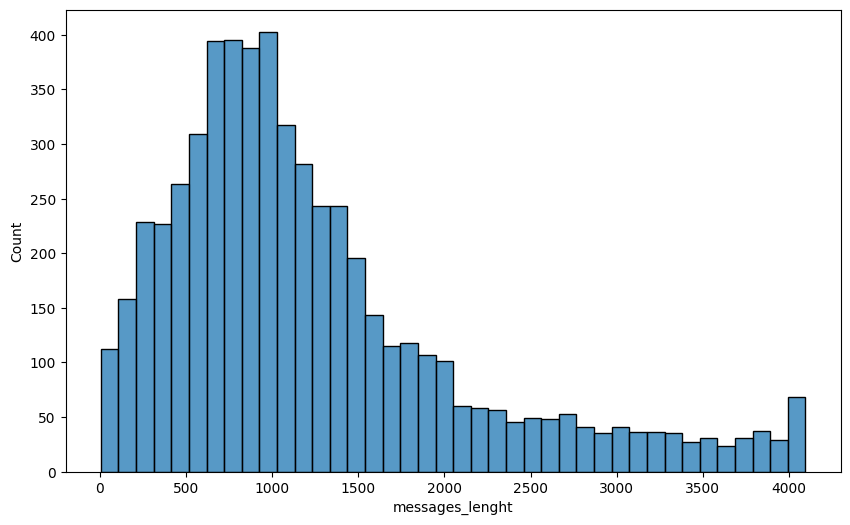

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['message_lenght'])
plt.xlabel("messages_lenght")

Text(0.5, 0, 'Count of words')

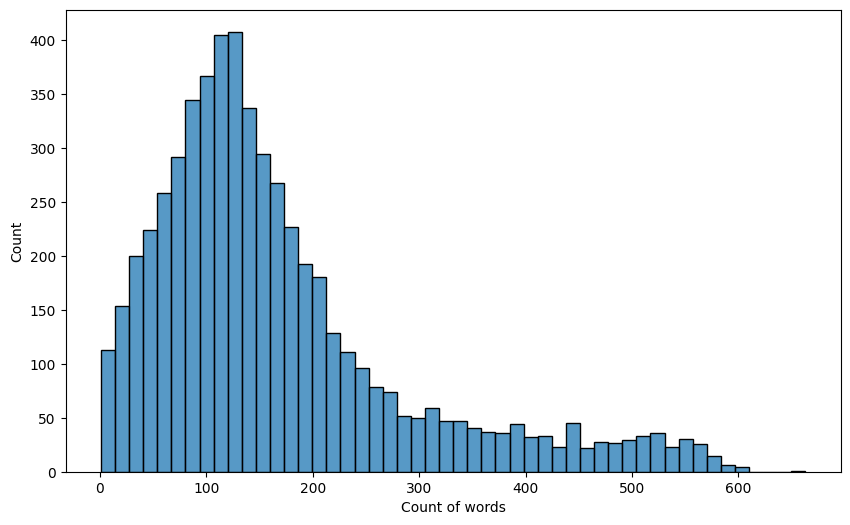

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['word_count'])
plt.xlabel("Count of words")

**Удалим слишком короткие и слишком длинные сообщения**

In [67]:
filtered_df = df[df['word_count'] <= 400].copy()

filtered_df = filtered_df[
    (filtered_df['message_lenght']) >= 20 & 
    (filtered_df['message_lenght'] <= 2500)
]
    
print(f"После фильтрации: {len(filtered_df)} сообщений")
print(f"Удалено: {len(df) - len(filtered_df)} сообщений")

После фильтрации: 5173 сообщений
Удалено: 409 сообщений


**Предобработка текстов**

In [68]:
# создаём морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

if 'russian_stopwords' not in locals():
      russian_stopwords = stopwords.words("russian")

extra_stopwords = ['наш', 'свой', 'который', 'это', 'весь', 'сам']

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Приведение к нижнему регистру
        text = text.lower()
        text = re.sub(r'[^а-яё]', ' ', text) # Удаление пунктуации, кроме пробелов
        # разбиваем на слова
        words = text.split()
        # приводим к леммам, убираем стоп-слова и короткие слова (это важно для тематическго моделирования)
        lemmas = [morph.parse(word)[0].normal_form for word in words if 
                  word not in russian_stopwords and 
                  morph.parse(word)[0].normal_form not in extra_stopwords and 
                  len(word) > 2]
        texts_as_lists.append(lemmas)
        return " ".join(lemmas)
    return "" # Возвращаем пустую строку для нестроковых значений


print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'message' in filtered_df.columns:
    tqdm.pandas()
    filtered_df['processed_text'] = filtered_df['message'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(filtered_df.head())


Начало предобработки текста...


  0%|          | 0/5173 [00:00<?, ?it/s]

100%|██████████| 5173/5173 [00:47<00:00, 108.16it/s]

Предобработка текста завершена.


message  message_lenght  \
0  Поздравляем, самые любимые 💙\n\nВы научили нас...             399   
1  ☀️ Как победить сезонную хандру? \n\nУчастники...             784   
2  👦На борту наших рейсов юные пассажиры ведут се...             767   
3  ❄️ Только представьте: полёт в сопровождении о...             603   
4  ✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...             943   

   word_count                                     processed_text  
0          62  поздравлять самый любимый научить смотреть мир...  
1         155  победить сезонный хандра участник аэрофлот бон...  
2         121  борт рейс юный пассажир вести образцово всё пр...  
3          83  представить полёт сопровождение оркестр борт р...  
4         186  пока составлять список подарок новогодний праз...

In [69]:
texts = filtered_df['processed_text']

**Облако слов**

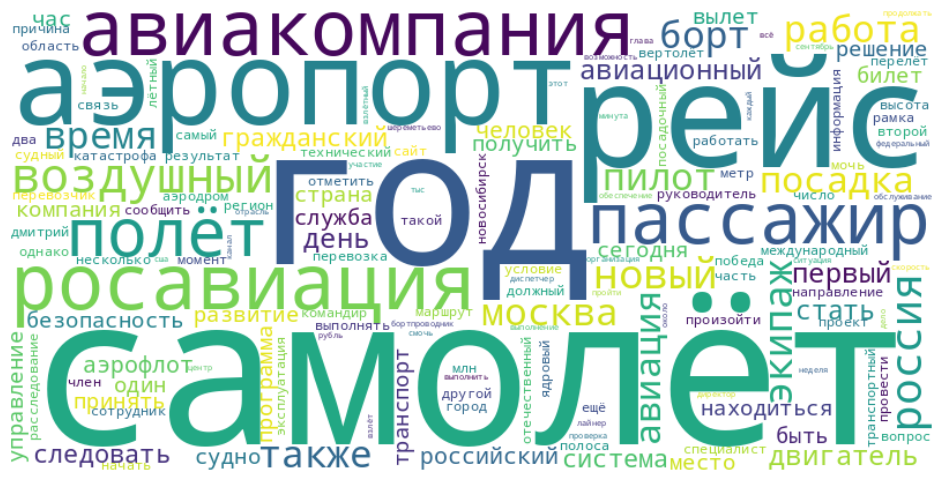

In [70]:
def create_wordcloud(texts, max_words=100):
    all_text = ' '.join(texts)
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        collocations=False
    ).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud


wordcloud = create_wordcloud(filtered_df['processed_text'], max_words=150)

## Обучение моделей

### Настройка mlflow

In [ ]:
experiment = mlflow.create_experiment(name="topic_modeling", artifact_location='my-artifacts')

In [71]:
mlflow.set_tracking_uri("../mlruns")

In [72]:
client = MlflowClient()

In [73]:
experiment = mlflow.get_experiment_by_name("topic_modeling")
experiment_id = experiment.experiment_id 

In [74]:
data_info = {"git_commit": "a5f2382b5f04cbafae837ecd13b8bd66efd38e92",
             "data_path": "data/processed/cleaned_poosts_v1.csv",
             "data_hash": "43641f5e22e2bc2517f22bc2f54d0a50.dir"}

In [75]:
def log_topics_to_mlflow(lda_model, feature_names, n_words=10, filename="./temp-data/topics.txt"):
    """Сохраняет топ-слов тем в файл и логирует в MLflow"""
    
    topics_text = "Топ-слова для каждой темы:\n\n"
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics_text += f"Тема #{topic_idx + 1}: "
        topics_text += ", ".join(top_words) + "\n\n"
    
    # Сохраняем в временный файл
    with open(filename, "w", encoding="utf-8") as f:
        f.write(topics_text)
    
    # Логируем как артефакт
    mlflow.log_artifact(filename)
    
    return topics_text

In [76]:
def register_model(run_name, data_info, n_topics, model_type, vectorizer, model, feature_names, version="production"):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
        # Логируем параметры
        mlflow.log_param("n_topics", n_topics)
        mlflow.log_param("model_type", model_type)
        mlflow.log_param("version", version)
        mlflow.log_param("vectorizer", vectorizer)

        mlflow.log_param("git_commit", data_info["git_commit"])
        mlflow.log_param("data_path", data_info["data_path"])
        mlflow.log_param("data_hash", data_info["data_hash"])

        
        # Логируем модель с регистрацией
        model_info = mlflow.sklearn.log_model(
            model, 
            f"{model_type}_model",
            registered_model_name=f"{model_type}_Topic_Model"
        )

        log_topics_to_mlflow(model, feature_names)
        
        print(f" Модель зарегистрирована:")
        print(f"   Run ID: {model_info.run_id}")
        print(f"   Model URI: {model_info.model_uri}")

### LDA

In [77]:
def train_lda_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение LDA модели
    """
    # Векторизация текстов
    vectorizer = CountVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
    
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=random_state,
        max_iter=10,
        learning_method='online'
    )
    
    lda.fit(X)
    
    return lda, vectorizer

In [78]:
lda_models = []

def experiment_lda_with_mlflow(texts, data_info, n_topics_list=[5, 10, 15]):
    """
    Проведение экспериментов с разным количеством тем
    """
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"LDA_{n_topics}_topics"):
            # Логируем параметры
            mlflow.log_param("model_type", "LDA")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("max_features", 1000)
            mlflow.log_param("vectorizer", "BoW")

            mlflow.log_param("git_commit", data_info["git_commit"])
            mlflow.log_param("data_path", data_info["data_path"])
            mlflow.log_param("data_hash", data_info["data_hash"])
            
            # Обучаем модель
            lda, vectorizer = train_lda_model(texts, n_topics=n_topics)
            lda_models.append([lda, vectorizer])
            log_topics_to_mlflow(lda, vectorizer.get_feature_names_out(), n_words=15)
            print(f"Эксперимент с {n_topics} темами завершен")
            print("-" * 50)


In [79]:
experiment_lda_with_mlflow(texts, data_info, n_topics_list=[5, 10, 15])

Размер матрицы: (5173, 2000)
Количество тем: 5
Эксперимент с 5 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 2000)
Количество тем: 10
Эксперимент с 10 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 2000)
Количество тем: 15
Эксперимент с 15 темами завершен
--------------------------------------------------


In [80]:
lda_best_model = lda_models[1]

In [ ]:
register_model("LDA_best_model_v3", 
                 data_info, 
                 10, 
                 "LDA", 
                 "BoW", 
                 lda_best_model[0],
                 lda_best_model[1].get_feature_names_out())

2025/12/01 14:42:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/01 14:42:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2025/12/01 14:42:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Модель зарегистрирована:
   Run ID: 70f5996b0c664e709c9678f76def6a4a
   Model URI: models:/m-421ff2f5bf7b43f385897b274c11a395


Registered model 'LDA_Topic_Model' already exists. Creating a new version of this model...
Created version '3' of model 'LDA_Topic_Model'.


In [ ]:
lda_topics = ['Пассажирский опыт',
              'Расписание и частота рейсов',
              'Эксплуатация авиатехники',
              'Развитие отечественной авиации',
              'Административно-финансовые аспекты',
              'Программы лояльности и коммерческие услуги',
              'Региональные перевозки и маршруты',
              'Авиационные происшествия и безопасность полетов',
              'Работа аэропортов и авиакомпаний',
              'Памятные даты и праздники']

### NMF

In [81]:
def train_nmf_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение NMF модели
    """
    # Векторизация текстов с TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
       
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение NMF
    nmf = NMF(
        n_components=n_topics,
        random_state=random_state,
        max_iter=200,
        init='nndsvda'
    )
    
    nmf.fit(X)
    
    return nmf, vectorizer

In [82]:
nmf_models = []

def experiment_nmf_with_mlflow(texts, data_info, n_topics_list=[5, 10, 15]):
    """
    Проведение экспериментов с разным количеством тем для NMF
    """
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment_id, run_name=f"NMF_{n_topics}_topics"):
            # Логируем параметры
            mlflow.log_param("model_type", "NMF")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("max_features", 1000)
            mlflow.log_param("vectorizer", "TF-IDF")

            mlflow.log_param("git_commit", data_info["git_commit"])
            mlflow.log_param("data_path", data_info["data_path"])
            mlflow.log_param("data_hash", data_info["data_hash"])
            
            # Обучаем модель
            nmf, vectorizer = train_nmf_model(texts, n_topics=n_topics)
            
            # Логируем топ-слова
            log_topics_to_mlflow(nmf, vectorizer.get_feature_names_out(), n_words=15, filename="./temp-data/topics.txt")
            
            nmf_models.append([nmf, vectorizer])

            print(f"NMF эксперимент с {n_topics} темами завершен")
            print("-" * 50)

In [83]:
experiment_nmf_with_mlflow(texts, data_info, n_topics_list=[6, 7, 8])

Размер матрицы: (5173, 2000)
Количество тем: 6
NMF эксперимент с 6 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 2000)
Количество тем: 7
NMF эксперимент с 7 темами завершен
--------------------------------------------------
Размер матрицы: (5173, 2000)
Количество тем: 8
NMF эксперимент с 8 темами завершен
--------------------------------------------------


In [84]:
nmf_best_model = nmf_models[2]

In [ ]:
register_model("NMF_best_model_v3", 
            data_info, 
            8, 
            "NMF", 
            "TF-IDF", 
            nmf_best_model[0],
            nmf_best_model[1].get_feature_names_out())
  

2025/12/01 16:03:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/01 16:03:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/12/01 16:03:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Модель зарегистрирована:
   Run ID: 0f59970f3f4447ddbcaf2f054258938c
   Model URI: models:/m-39ef74b180d74800ab316bc35534de91


Registered model 'NMF_Topic_Model' already exists. Creating a new version of this model...
Created version '3' of model 'NMF_Topic_Model'.


In [109]:
nmf_topics = ['Авиационные происшествия и безопасность полетов',
              'Руководство и регулирование (Росавиация)',
              'Региональные перевозки и маршруты',
              'Производство и испытания авиатехники',
              'Памятные даты и праздники',
              'Работа аэропортов и авиакомпаний',
              'Инфраструктура и строительство аэропортов',
              'Пассажиропоток и статистика перевозок']

### BERTopic

In [85]:
def train_bertopic_model(texts, n_topics=10, min_topic_size=15, random_state=42):

    embedding_model = SentenceTransformer("cointegrated/rubert-tiny2")
    
    umap_model = UMAP(
        n_neighbors=10,         
        n_components=3,          
        min_dist=0.05,          
        metric='cosine',
        random_state=random_state
    )
    
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_topic_size,
        min_samples=5,          
        cluster_selection_method='leaf', 
        cluster_selection_epsilon=0.1,   
        metric='euclidean',
        prediction_data=True
    )
    
    vectorizer_model = CountVectorizer(
        stop_words=russian_stopwords + extra_stopwords,
        ngram_range=(1, 1),    
        min_df=2,
        max_df=0.8
    )
    
    print(f" BERTopic:")
    print(f"   • Русская модель: rubert-tiny2")
    print(f"   • Ожидаемых тем: {n_topics}")
    print(f"   • Min topic size: {min_topic_size}")
    print(f"   • UMAP components: 3 (было 5)")
    print(f"   • HDBSCAN method: leaf")
    
    # Создание и обучение BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,   
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,   
        representation_model=KeyBERTInspired(),
        nr_topics=n_topics,
        language=None, 
        calculate_probabilities=True,
        verbose=True
    )
    
    # Обучение модели
    topics, probabilities = topic_model.fit_transform(texts)
    
    return topic_model, topics, probabilities

In [86]:
def log_bertopic_to_mlflow(topic_model, n_words=10, filename="./temp-data/topics_bertopic.txt"):
    """Сохраняет топ-слов тем BERTopic в файл и логирует в MLflow"""
    
    # Получаем информацию о темах
    topic_info = topic_model.get_topic_info()
    
    topics_text = "Топ-слова для каждой темы (BERTopic):\n\n"
    
    # -1 тема - это выбросы (outliers)
    for idx, row in topic_info.iterrows():
        topic_id = int(row["Topic"])
        count = row["Count"]
        
        if topic_id == -1:
            topics_text += f"Тема #{topic_id} (Выбросы, {count} документов):\n"
        else:
            topics_text += f"Тема #{topic_id} ({count} документов):\n"
        
        # Получаем топ-слова для темы
        if topic_id in topic_model.get_topics():
            topic_words = topic_model.get_topic(topic_id)
            top_words = [word for word, _ in topic_words[:n_words]]
            topics_text += ", ".join(top_words) + "\n\n"
        else:
            topics_text += "Нет слов для этой темы\n\n"
    
    # Также логируем иерархию тем
    topics_text += "\n\nИерархия тем:\n"
    hierarchical_topics = topic_model.hierarchical_topics(texts)
    for i in range(min(20, len(hierarchical_topics))):
        topics_text += f"{hierarchical_topics.iloc[i]}\n"
    
    # Сохраняем в временный файл
    with open(filename, "w", encoding="utf-8") as f:
        f.write(topics_text)
    
    # Логируем как артефакт
    mlflow.log_artifact(filename)
    
    return topics_text

In [87]:
def register_bertopic_model(run_name, data_info, topic_model, n_topics, min_topic_size, 
                           embedding_model_name, version="production"):

    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
        # Логируем параметры
        mlflow.log_param("model_type", "BERTopic")
        mlflow.log_param("n_topics", n_topics)
        mlflow.log_param("min_topic_size", min_topic_size)
        mlflow.log_param("embedding_model", embedding_model_name)
        mlflow.log_param("version", version)
        
        # Параметры UMAP
        if hasattr(topic_model.umap_model, 'n_components'):
            mlflow.log_param("umap_n_components", topic_model.umap_model.n_components)
        if hasattr(topic_model.umap_model, 'n_neighbors'):
            mlflow.log_param("umap_n_neighbors", topic_model.umap_model.n_neighbors)
        if hasattr(topic_model.umap_model, 'min_dist'):
            mlflow.log_param("umap_min_dist", topic_model.umap_model.min_dist)
        
        # Параметры HDBSCAN
        if hasattr(topic_model.hdbscan_model, 'min_cluster_size'):
            mlflow.log_param("hdbscan_min_cluster_size", 
                           topic_model.hdbscan_model.min_cluster_size)
        if hasattr(topic_model.hdbscan_model, 'cluster_selection_method'):
            mlflow.log_param("hdbscan_method", 
                           topic_model.hdbscan_model.cluster_selection_method)
        
        # Информация о данных
        mlflow.log_param("git_commit", data_info["git_commit"])
        mlflow.log_param("data_path", data_info["data_path"])
        mlflow.log_param("data_hash", data_info["data_hash"])
        
        # Получаем метрики модели
        topic_info = topic_model.get_topic_info()
        n_topics_found = len(topic_info[topic_info["Topic"] != -1])
        outliers = topic_info[topic_info["Topic"] == -1]["Count"].values[0] if -1 in topic_info["Topic"].values else 0
        
        # Логируем метрики
        mlflow.log_metric("n_topics_found", n_topics_found)
        mlflow.log_metric("outliers_count", outliers)
        mlflow.log_metric("outliers_percent", outliers/len(topic_model.get_document_info(texts))*100 
                         if hasattr(topic_model, 'get_document_info') and texts is not None else 0)
        
        # Логируем модель с регистрацией
        model_info = mlflow.sklearn.log_model(
            topic_model, 
            "bertopic_model",
            registered_model_name=f"BERTopic_Model"
        )
        
        # Логируем информацию о темах
        log_bertopic_to_mlflow(topic_model, n_words=15)
        
        # Сохраняем визуализации как артефакты
        try:
            # Визуализация тем
            fig = topic_model.visualize_topics()
            fig.write_html(".temp-charts/topics_visualization.html")
            mlflow.log_artifact(".temp-charts/topics_visualization.html")
            
            # Визуализация барчартов
            fig_barchart = topic_model.visualize_barchart(top_n_topics=min(10, n_topics_found))
            fig_barchart.write_html(".temp-charts/topics_barchart.html")
            mlflow.log_artifact(".temp-charts/topics_barchart.html")
            
            # Иерархическая кластеризация
            fig_hierarchy = topic_model.visualize_hierarchy()
            fig_hierarchy.write_html(".temp-charts/topics_hierarchy.html")
            mlflow.log_artifact(".temp-charts/topics_hierarchy.html")
        except Exception as e:
            print(f"Не удалось создать визуализации: {e}")
        
        print(f" Модель BERTopic зарегистрирована:")
        print(f"   Run ID: {model_info.run_id}")
        print(f"   Model URI: {model_info.model_uri}")
        print(f"   Найдено тем: {n_topics_found}")
        print(f"   Выбросы: {outliers}")
        
        return model_info

In [88]:
def experiment_bertopic_with_mlflow(texts, data_info, n_topics_list=[8, 10, 12], min_topic_sizes=[20, 30]):
    """
    Улучшенная версия экспериментов с BERTopic
    """
    bertopic_models = []
    
    for n_topics in n_topics_list:
        for min_topic_size in min_topic_sizes:
            run_name = f"BERTopic_opt_{n_topics}_{min_topic_size}"
            
            with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
                mlflow.log_param("model_type", "BERTopic_optimized")
                mlflow.log_param("n_topics", n_topics)
                mlflow.log_param("min_topic_size", min_topic_size)
                mlflow.log_param("embedding_model", "rubert-tiny2") 
                mlflow.log_param("umap_components", 3)
                mlflow.log_param("hdbscan_method", "leaf")
                mlflow.log_param("vectorizer_ngrams", "1-2")
                
                mlflow.log_param("git_commit", data_info["git_commit"])
                mlflow.log_param("data_path", data_info["data_path"])
                mlflow.log_param("data_hash", data_info["data_hash"])
                
                print(f"\nОбучение BERTopic: {n_topics} тем, min_size={min_topic_size}")
                
                try:
                    topic_model, topics, probabilities = train_bertopic_model(
                        texts, 
                        n_topics=n_topics,
                        min_topic_size=min_topic_size
                    )
                    
                    # Анализ результатов
                    topic_info = topic_model.get_topic_info()
                    n_topics_found = len(topic_info[topic_info["Topic"] != -1])
                    outliers = topic_info[topic_info["Topic"] == -1]["Count"].values[0] if -1 in topic_info["Topic"].values else 0
                    
                    print(f" Результаты BERTopic:")
                    print(f"   • Найдено тем: {n_topics_found}")
                    print(f"   • Выбросов: {outliers} ({outliers/len(texts)*100:.1f}%)")
                    print(f"   • Средний размер темы: {(len(texts)-outliers)/max(1, n_topics_found):.0f} док.")
                    
                    # Логируем метрики
                    mlflow.log_metric("n_topics_found", n_topics_found)
                    mlflow.log_metric("outliers_count", outliers)
                    mlflow.log_metric("outliers_percent", outliers/len(texts)*100)
                    
                    # Сохраняем модель
                    bertopic_models.append({
                        'model': topic_model,
                        'topics': topics,
                        'params': {'n_topics': n_topics, 'min_topic_size': min_topic_size},
                        'metrics': {'n_found': n_topics_found, 'outliers': outliers}
                    })
                    
                    # Логируем топ-слова
                    log_bertopic_to_mlflow(topic_model, n_words=15)
                    
                     # Сохраняем визуализацию тем
                    try:
                        fig = topic_model.visualize_topics()
                        fig.write_html("./temp-charts/topics_visualization.html")
                        mlflow.log_artifact("./temp-charts/topics_visualization.html")
                        
                        fig_barchart = topic_model.visualize_barchart(top_n_topics=min(10, n_topics_found))
                        fig_barchart.write_html(".temp-charts/topics_barchart.html")
                        mlflow.log_artifact(".temp-charts/topics_barchart.html")
                    except:
                        print("Не удалось создать визуализации")

                    # Показываем топ-5 тем
                    if n_topics_found > 0:
                        print(f"\n Топ-5 тем BERTopic:")
                        sorted_topics = topic_info[topic_info.Topic != -1].sort_values('Count', ascending=False)
                        
                        for i, (_, row) in enumerate(sorted_topics.head(5).iterrows(), 1):
                            topic_id = row['Topic']
                            count = row['Count']
                            words = topic_model.get_topic(topic_id)
                            top_words = [word for word, _ in words[:5]]
                            print(f"   {i}. Тема #{topic_id} ({count} док.): {', '.join(top_words)}")
                    
                    print(f" BERTopic завершен успешно!")
                    
                except Exception as e:
                    print(f"Ошибка при обучении модели: {str(e)}")
                    mlflow.log_param("error", str(e))
                
                print("-" * 50)
    
    return bertopic_models

In [89]:
bertopic_models = experiment_bertopic_with_mlflow(
    texts, 
    data_info, 
    n_topics_list=[8, 10, 12], 
    min_topic_sizes = [30, 40, 50]      
)


Обучение BERTopic: 8 тем, min_size=30


2025-12-03 17:06:46,426 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 8
   • Min topic size: 30
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:39<00:00,  4.13it/s]
2025-12-03 17:07:25,774 - BERTopic - Embedding - Completed ✓
2025-12-03 17:07:25,775 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:07:43,993 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:07:43,995 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:07:44,374 - BERTopic - Cluster - Completed ✓
2025-12-03 17:07:44,375 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:07:44,776 - BERTopic - Representation - Completed ✓
2025-12-03 17:07:44,776 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:07:44,783 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:07:46,139 - BERTopic - Representation - Completed ✓
2025-12-03 17:07:46,142 - BERTopic - Topic reduction - Reduced number of topics from 47 to 8


 Результаты BERTopic:
   • Найдено тем: 7
   • Выбросов: 2362 (45.7%)
   • Средний размер темы: 402 док.


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (1171 док.): сертификация, вертолёт, аэродром, судно, беспилотный
   2. Тема #1 (712 док.): иркутск, новосибирск, путешествие, пассажиропоток, путешественник
   3. Тема #2 (375 док.): аэродром, авиадиспетчер, авиакатастрофа, транспортный, вертолёт
   4. Тема #3 (196 док.): шоу, гастрономический, блогер, бренд, авиаребус
   5. Тема #4 (171 док.): первокурсник, профессионализм, выпускник, авиадиспетчер, профессиональный
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 8 тем, min_size=40


2025-12-03 17:07:55,022 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 8
   • Min topic size: 40
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:38<00:00,  4.23it/s]
2025-12-03 17:08:33,511 - BERTopic - Embedding - Completed ✓
2025-12-03 17:08:33,512 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:08:38,077 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:08:38,078 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:08:38,353 - BERTopic - Cluster - Completed ✓
2025-12-03 17:08:38,354 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:08:38,643 - BERTopic - Representation - Completed ✓
2025-12-03 17:08:38,645 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:08:38,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:08:39,799 - BERTopic - Representation - Completed ✓
2025-12-03 17:08:39,801 - BERTopic - Topic reduction - Reduced number of topics from 37 to 8


 Результаты BERTopic:
   • Найдено тем: 7
   • Выбросов: 2351 (45.4%)
   • Средний размер темы: 403 док.


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (1235 док.): бортпроводник, сертификация, вертолёт, аэродром, судно
   2. Тема #1 (616 док.): пассажиропоток, авиаперевозка, транспортный, октябрь, бортпроводник
   3. Тема #2 (375 док.): новосибирск, якутск, путешествие, путешественник, красноярск
   4. Тема #3 (196 док.): шоу, гастрономический, блогер, бренд, авиаребус
   5. Тема #4 (175 док.): героизм, праздник, ветеран, исторический, россиянин
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 8 тем, min_size=50


2025-12-03 17:08:44,333 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 8
   • Min topic size: 50
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:35<00:00,  4.52it/s]
2025-12-03 17:09:20,331 - BERTopic - Embedding - Completed ✓
2025-12-03 17:09:20,331 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:09:24,838 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:09:24,838 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:09:25,082 - BERTopic - Cluster - Completed ✓
2025-12-03 17:09:25,083 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:09:25,332 - BERTopic - Representation - Completed ✓
2025-12-03 17:09:25,333 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:09:25,339 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:09:26,685 - BERTopic - Representation - Completed ✓
2025-12-03 17:09:26,688 - BERTopic - Topic reduction - Reduced number of topics from 31 to 8


 Результаты BERTopic:
   • Найдено тем: 7
   • Выбросов: 1792 (34.6%)
   • Средний размер темы: 483 док.


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (1649 док.): бортпроводник, вертолёт, аэродром, двигатель, катастрофа
   2. Тема #1 (539 док.): пассажиропоток, авиаперевозка, столица, бортпроводник, аэродром
   3. Тема #2 (375 док.): якутск, путешествие, путешественник, авиабилет, путешествовать
   4. Тема #3 (315 док.): профессионализм, ветеран, военный, праздник, летие
   5. Тема #4 (278 док.): шоу, выставка, гастрономический, форум, блогер
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 10 тем, min_size=30


2025-12-03 17:09:30,758 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 10
   • Min topic size: 30
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:39<00:00,  4.11it/s]
2025-12-03 17:10:10,375 - BERTopic - Embedding - Completed ✓
2025-12-03 17:10:10,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:10:15,157 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:10:15,157 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:10:15,494 - BERTopic - Cluster - Completed ✓
2025-12-03 17:10:15,494 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:10:15,787 - BERTopic - Representation - Completed ✓
2025-12-03 17:10:15,788 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:10:15,797 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:10:17,320 - BERTopic - Representation - Completed ✓
2025-12-03 17:10:17,323 - BERTopic - Topic reduction - Reduced number of topics from 47 to 10


 Результаты BERTopic:
   • Найдено тем: 9
   • Выбросов: 2362 (45.7%)
   • Средний размер темы: 312 док.


100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (602 док.): авиатехник, беспилотник, сертификационный, сертификация, аэродром
   2. Тема #1 (569 док.): вертолёт, пассажирка, стюардесса, корабль, аэродром
   3. Тема #2 (414 док.): иркутск, новосибирск, якутск, путешествие, путешественник
   4. Тема #3 (375 док.): аэродром, авиадиспетчер, авиакатастрофа, транспортный, вертолёт
   5. Тема #4 (298 док.): пассажиропоток, авиаперевозка, транспортный, авиасообщение, октябрь
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 10 тем, min_size=40


2025-12-03 17:10:22,150 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 10
   • Min topic size: 40
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:37<00:00,  4.31it/s]
2025-12-03 17:10:59,876 - BERTopic - Embedding - Completed ✓
2025-12-03 17:10:59,877 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:11:04,434 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:11:04,436 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:11:04,710 - BERTopic - Cluster - Completed ✓
2025-12-03 17:11:04,711 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:11:05,004 - BERTopic - Representation - Completed ✓
2025-12-03 17:11:05,005 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:11:05,010 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:11:06,572 - BERTopic - Representation - Completed ✓
2025-12-03 17:11:06,577 - BERTopic - Topic reduction - Reduced number of topics from 37 to 10


 Результаты BERTopic:
   • Найдено тем: 9
   • Выбросов: 2351 (45.4%)
   • Средний размер темы: 314 док.


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (752 док.): авиатехник, сертификационный, беспилотник, сертификация, госкорпорация
   2. Тема #1 (539 док.): пассажиропоток, транспортный, бортпроводник, август, пилот
   3. Тема #2 (483 док.): бортпроводник, пилот, вертолёт, аэродром, экипаж
   4. Тема #3 (375 док.): иркутск, новосибирск, якутск, путешествие, авиабилет
   5. Тема #4 (196 док.): шоу, гастрономический, блогер, бренд, авиаребус
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 10 тем, min_size=50


2025-12-03 17:11:11,601 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 10
   • Min topic size: 50
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:36<00:00,  4.42it/s]
2025-12-03 17:11:48,477 - BERTopic - Embedding - Completed ✓
2025-12-03 17:11:48,478 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:11:53,104 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:11:53,105 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:11:53,362 - BERTopic - Cluster - Completed ✓
2025-12-03 17:11:53,363 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:11:53,655 - BERTopic - Representation - Completed ✓
2025-12-03 17:11:53,655 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:11:53,662 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:11:55,163 - BERTopic - Representation - Completed ✓
2025-12-03 17:11:55,167 - BERTopic - Topic reduction - Reduced number of topics from 31 to 10


 Результаты BERTopic:
   • Найдено тем: 9
   • Выбросов: 1792 (34.6%)
   • Средний размер темы: 376 док.


100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (1649 док.): пилот, вертолёт, экипаж, аэродром, двигатель
   2. Тема #1 (488 док.): бортпроводник, аэродром, пилот, вертолёт, экипаж
   3. Тема #2 (375 док.): новосибирск, якутск, авиабилет, путешествие, путешественник
   4. Тема #3 (278 док.): шоу, гастрономический, выставка, форум, блогер
   5. Тема #4 (175 док.): героизм, праздник, ветеран, исторический, россиянин
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 12 тем, min_size=30


2025-12-03 17:11:59,568 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 12
   • Min topic size: 30
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:38<00:00,  4.25it/s]
2025-12-03 17:12:37,906 - BERTopic - Embedding - Completed ✓
2025-12-03 17:12:37,907 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:12:42,530 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:12:42,531 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:12:42,888 - BERTopic - Cluster - Completed ✓
2025-12-03 17:12:42,889 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:12:43,188 - BERTopic - Representation - Completed ✓
2025-12-03 17:12:43,190 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:12:43,195 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:12:45,063 - BERTopic - Representation - Completed ✓
2025-12-03 17:12:45,068 - BERTopic - Topic reduction - Reduced number of topics from 47 to 12


 Результаты BERTopic:
   • Найдено тем: 11
   • Выбросов: 2362 (45.7%)
   • Средний размер темы: 256 док.


100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (602 док.): авиатехник, беспилотник, сертификационный, сертификация, аэродромный
   2. Тема #1 (401 док.): вертолёт, аэродром, корабль, двигатель, космонавт
   3. Тема #2 (375 док.): аэродром, авиадиспетчер, авиакатастрофа, вертолёт, судно
   4. Тема #3 (306 док.): якутск, декабрь, четверг, вторник, понедельник
   5. Тема #4 (298 док.): пассажиропоток, авиаперевозчик, авиаперевозка, авиасообщение, туристический
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 12 тем, min_size=40


2025-12-03 17:12:49,927 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 12
   • Min topic size: 40
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:39<00:00,  4.12it/s]
2025-12-03 17:13:29,419 - BERTopic - Embedding - Completed ✓
2025-12-03 17:13:29,419 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:13:34,026 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:13:34,026 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:13:34,313 - BERTopic - Cluster - Completed ✓
2025-12-03 17:13:34,314 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:13:34,594 - BERTopic - Representation - Completed ✓
2025-12-03 17:13:34,595 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:13:34,600 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:13:36,452 - BERTopic - Representation - Completed ✓
2025-12-03 17:13:36,457 - BERTopic - Topic reduction - Reduced number of topics from 37 to 12


 Результаты BERTopic:
   • Найдено тем: 11
   • Выбросов: 2351 (45.4%)
   • Средний размер темы: 257 док.


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (696 док.): авиатехник, беспилотник, сертификационный, сертификация, вертолёт
   2. Тема #1 (488 док.): бортпроводник, аэродром, пилот, вертолёт, экипаж
   3. Тема #2 (483 док.): бортпроводник, пилот, вертолёт, экипаж, аэродром
   4. Тема #3 (375 док.): новосибирск, иркутск, якутск, авиабилет, красноярск
   5. Тема #4 (196 док.): шоу, гастрономический, бренд, блогер, авиаребус
 BERTopic завершен успешно!
--------------------------------------------------

Обучение BERTopic: 12 тем, min_size=50


2025-12-03 17:13:41,889 - BERTopic - Embedding - Transforming documents to embeddings.


 BERTopic:
   • Русская модель: rubert-tiny2
   • Ожидаемых тем: 12
   • Min topic size: 50
   • UMAP components: 3 (было 5)
   • HDBSCAN method: leaf


Batches: 100%|██████████| 162/162 [00:37<00:00,  4.33it/s]
2025-12-03 17:14:19,457 - BERTopic - Embedding - Completed ✓
2025-12-03 17:14:19,457 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 17:14:23,937 - BERTopic - Dimensionality - Completed ✓
2025-12-03 17:14:23,938 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 17:14:24,186 - BERTopic - Cluster - Completed ✓
2025-12-03 17:14:24,187 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-03 17:14:24,446 - BERTopic - Representation - Completed ✓
2025-12-03 17:14:24,447 - BERTopic - Topic reduction - Reducing number of topics
2025-12-03 17:14:24,452 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 17:14:25,930 - BERTopic - Representation - Completed ✓
2025-12-03 17:14:25,933 - BERTopic - Topic reduction - Reduced number of topics from 31 to 12


 Результаты BERTopic:
   • Найдено тем: 11
   • Выбросов: 1792 (34.6%)
   • Средний размер темы: 307 док.


100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Не удалось создать визуализации

 Топ-5 тем BERTopic:
   1. Тема #0 (1511 док.): пилот, экипаж, вертолёт, судно, аэродром
   2. Тема #1 (488 док.): бортпроводник, аэродром, пилот, вертолёт, экипаж
   3. Тема #2 (375 док.): новосибирск, якутск, путешественник, авиабилет, красноярск
   4. Тема #3 (201 док.): шоу, гастрономический, бренд, блогер, авиаребус
   5. Тема #4 (175 док.): героизм, празднование, ветеран, праздник, исторический
 BERTopic завершен успешно!
--------------------------------------------------


In [ ]:
register_bertopic_model("BERTopic_best_model_v1",
                         data_info, 
                         topic_model=bertopic_models[8]["model"],
                         n_topics=12,
                         min_topic_size=50,
                         embedding_model_name="cointegrated/rubert-tiny2",
                         )

2025/12/02 19:21:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 19:21:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/12/02 19:21:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'BERTopic_Model'.
Created version '1' of model 'BERTopic_Model'.
100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


 Модель BERTopic зарегистрирована:
   Run ID: 5271e7077f7b4075beb87a7329f6c296
   Model URI: models:/m-3869a002c3b14853ac34ad861da58658
   Найдено тем: 11
   Выбросы: 1792


In [90]:
bertopic_best_model = bertopic_models[8]

In [110]:
bertopic_topics = ['Общая авиационная лексика (смешанные посты)',
                   'Авиационные происшествия (с акцентом на работу экипажа)',
                   'Работа бортпроводников и наземных служб',
                   'Региональные авиаперевозки и расписание',
                   'Реклама',
                   'Памятные даты и патриотические события',
                   'Авиакатастрофы и расследования',
                   'Военная авиация',
                   'Персоналии и кадры',
                   'Отраслевые выставки и форумы',
                   'Расписания и акции',
                   'Статистика пассажиропотока и туризма']

### Визуализация моделей

In [168]:
def visualize_lda_nmf_model(model, vectorizer, topics, model_name, n_words=10):
    """
    Визуализация LDA модели
    """
    feature_names = vectorizer.get_feature_names_out()
    
    # Создаем первую фигуру для распределения тем и корреляций
    fig1, axes1 = plt.subplots(1, 1, figsize=(15, 6))

    # Гистограмма распределения весов тем
    topic_weights = model.components_.sum(axis=1)
    axes1.bar(topics, topic_weights)
    axes1.set_xlabel('Номер темы')
    axes1.set_ylabel('Общее количество отнесений слов к теме')
    axes1.set_title('Распределение важности тем')
    axes1.set_xticklabels(axes1.get_xticklabels(), rotation=45, ha='right')

    fig4, axes4 = plt.subplots(1, 1, figsize=(14, 9))
    # Heatmap корреляций тем
    topic_corr = np.corrcoef(model.components_)
    sns.heatmap(topic_corr, ax=axes4, cmap='coolwarm', 
                xticklabels=topics,
                yticklabels=topics,
                annot=True)
    axes4.set_title('Корреляции между темами')
    
    plt.tight_layout()
  
    # Облака слов в гриде 
    n_topics = len(model.components_)

    if n_topics <= 4:
        n_cols = 2
        n_rows = 2
    elif n_topics <= 9:
        n_cols = 3
        n_rows = 3
    else:
        n_cols = 4
        n_rows = 3
    
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4.5))
    axes2 = axes2.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        ax = axes2[topic_idx]
        topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[-n_words:]}
        
        wordcloud = WordCloud(width=400, height=300, 
                             background_color='white',
                             colormap='viridis',
                             max_words=n_words).generate_from_frequencies(topic_words)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(topics[topic_idx])
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(topic_idx + 1, len(axes2)):
        axes2[idx].axis('off')
    
    plt.suptitle(f'Облака слов для каждой темы {model_name}', fontsize=14)
    plt.tight_layout()

    # Топ-слова для всех тем
    fig3, axes3 = plt.subplots(n_cols, n_rows,
                               figsize=(15, 13))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(model.components_)))
    axes3 = axes3.flatten()
    fig3.suptitle('Топ-слова для тем')
    for idx, (topic, color) in enumerate(zip(model.components_, colors)):
        ax = axes3[idx]
        top_words_idx = topic.argsort()[-n_words:]
        top_words = [feature_names[i] for i in top_words_idx]
        weights = topic[top_words_idx]
        
        ax.barh(range(n_words), weights, color=color)
        ax.set_yticks(range(n_words))
        ax.set_yticklabels(top_words)
        ax.set_title(topics[idx])
        ax.set_xlabel('Вклад слова')
    
    # Скрываем пустые subplots
    for idx in range(len(model.components_), len(axes3)):
        axes3[idx].axis('off')
    
    plt.tight_layout()
    
    return fig1, fig2, fig3, fig4

### LDA

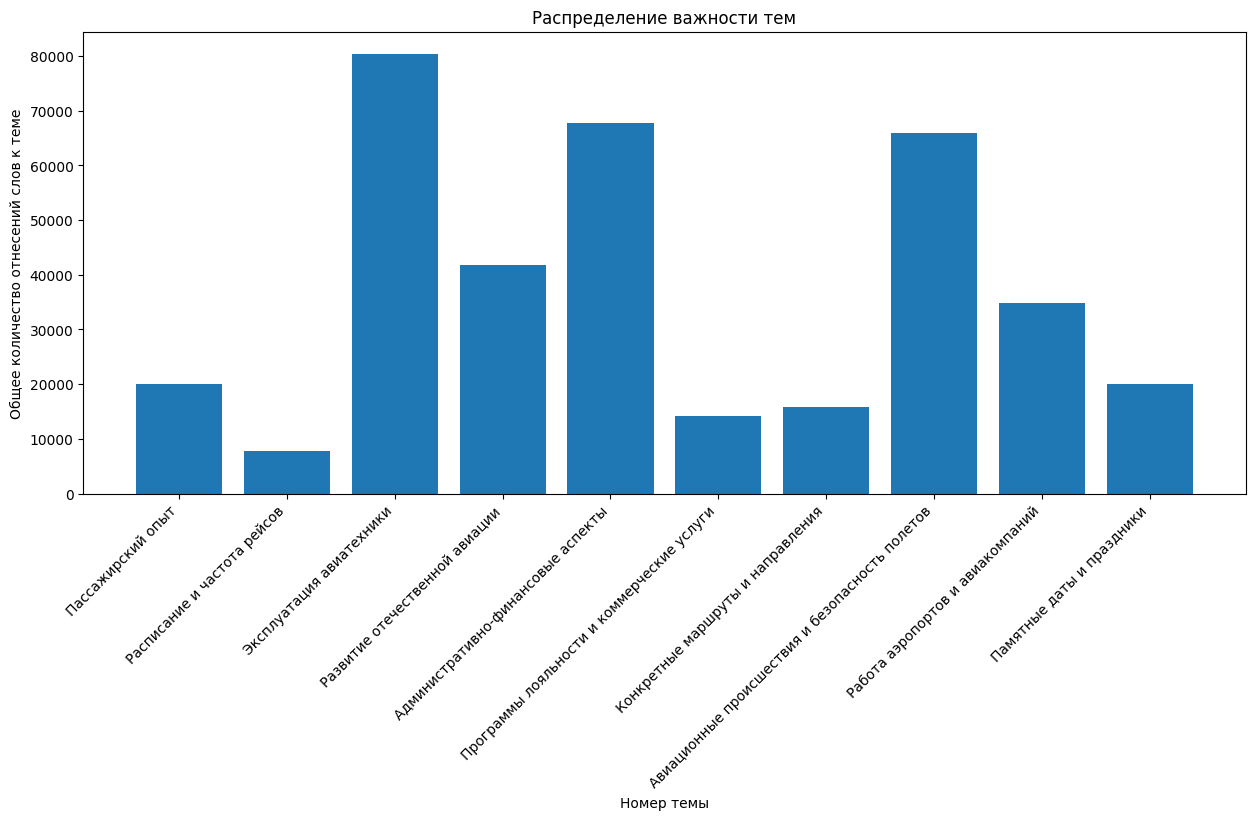

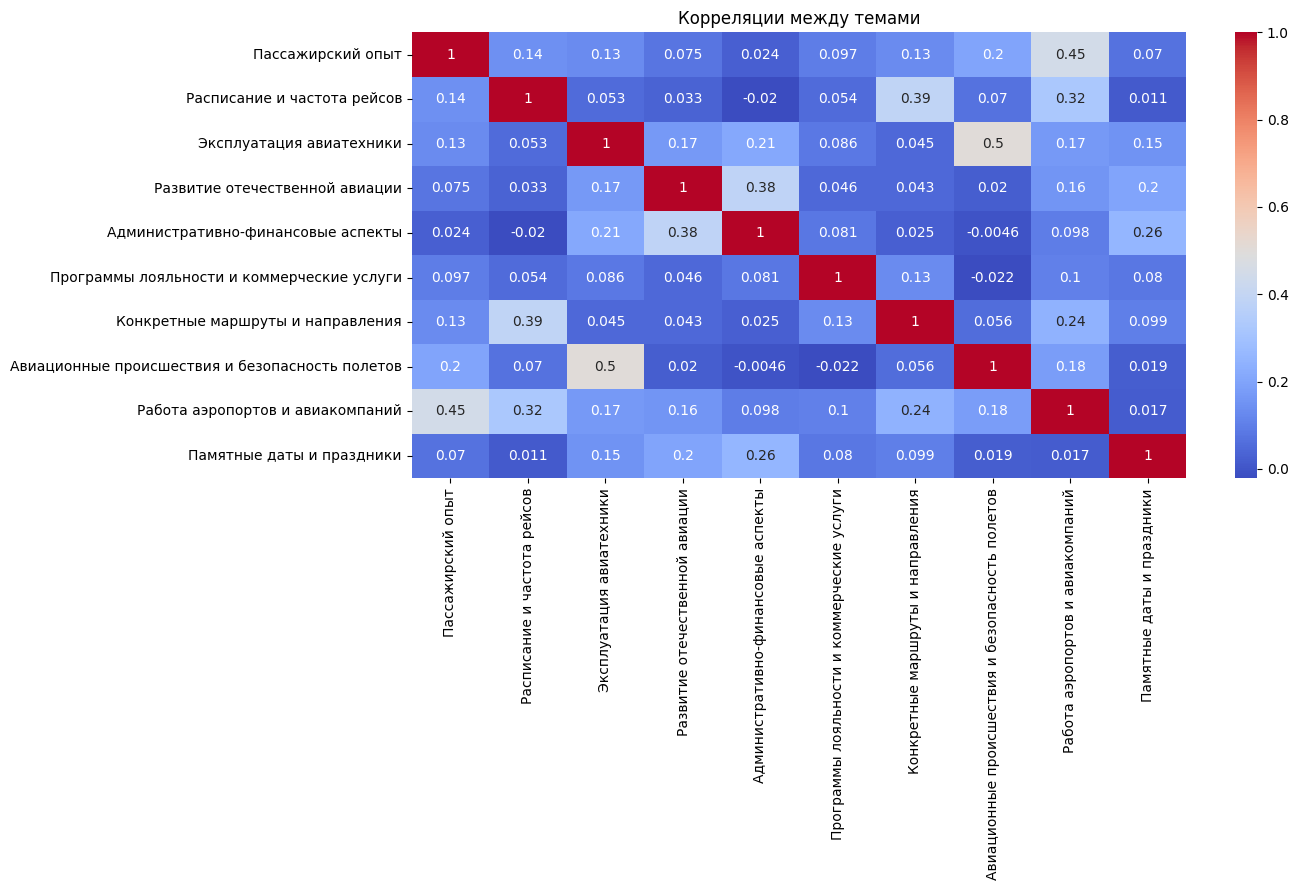

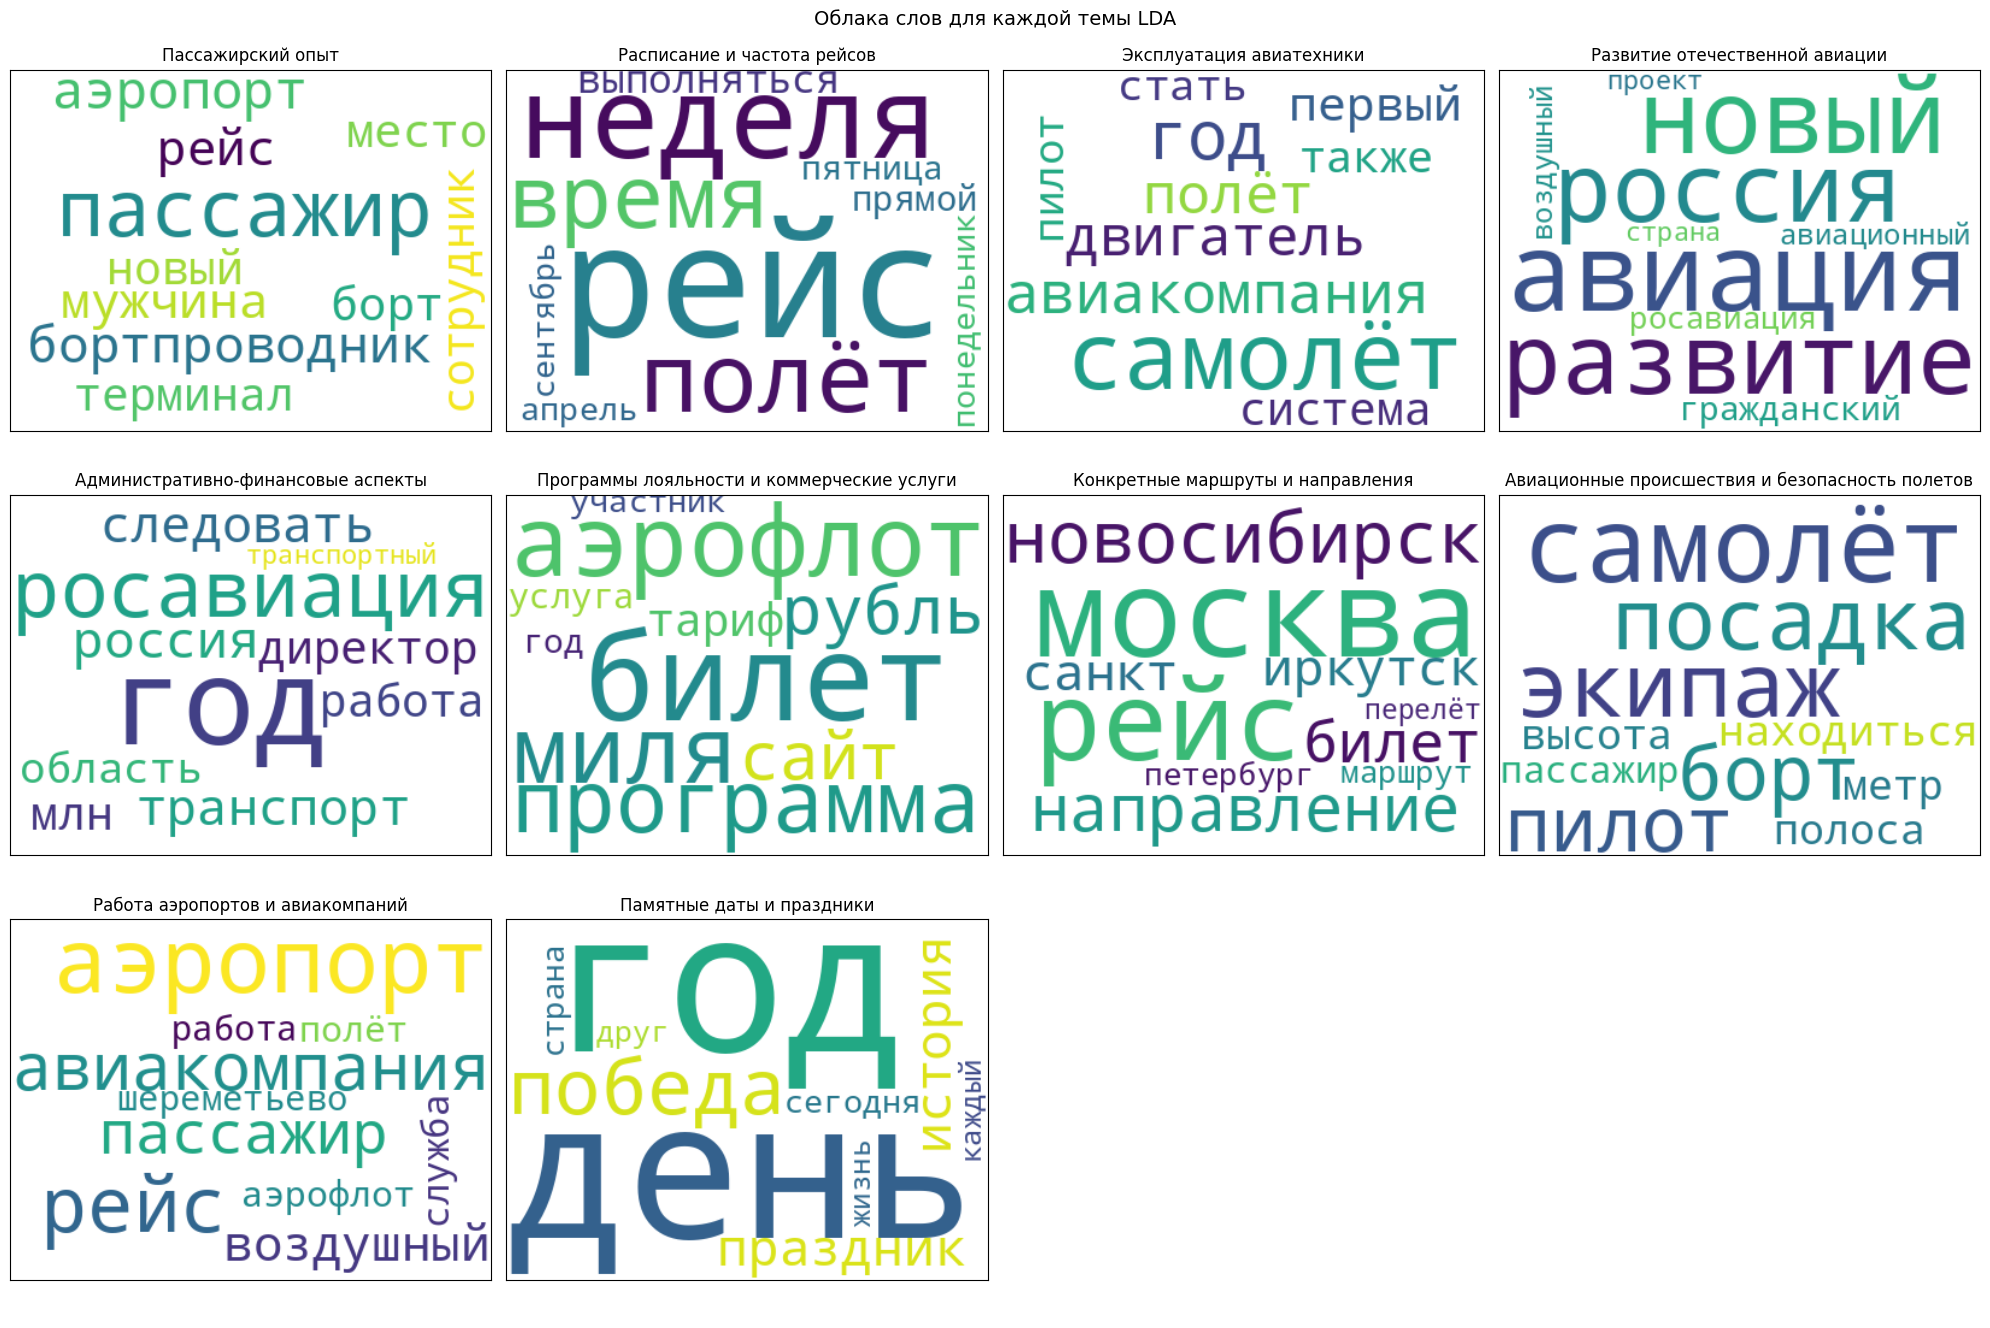

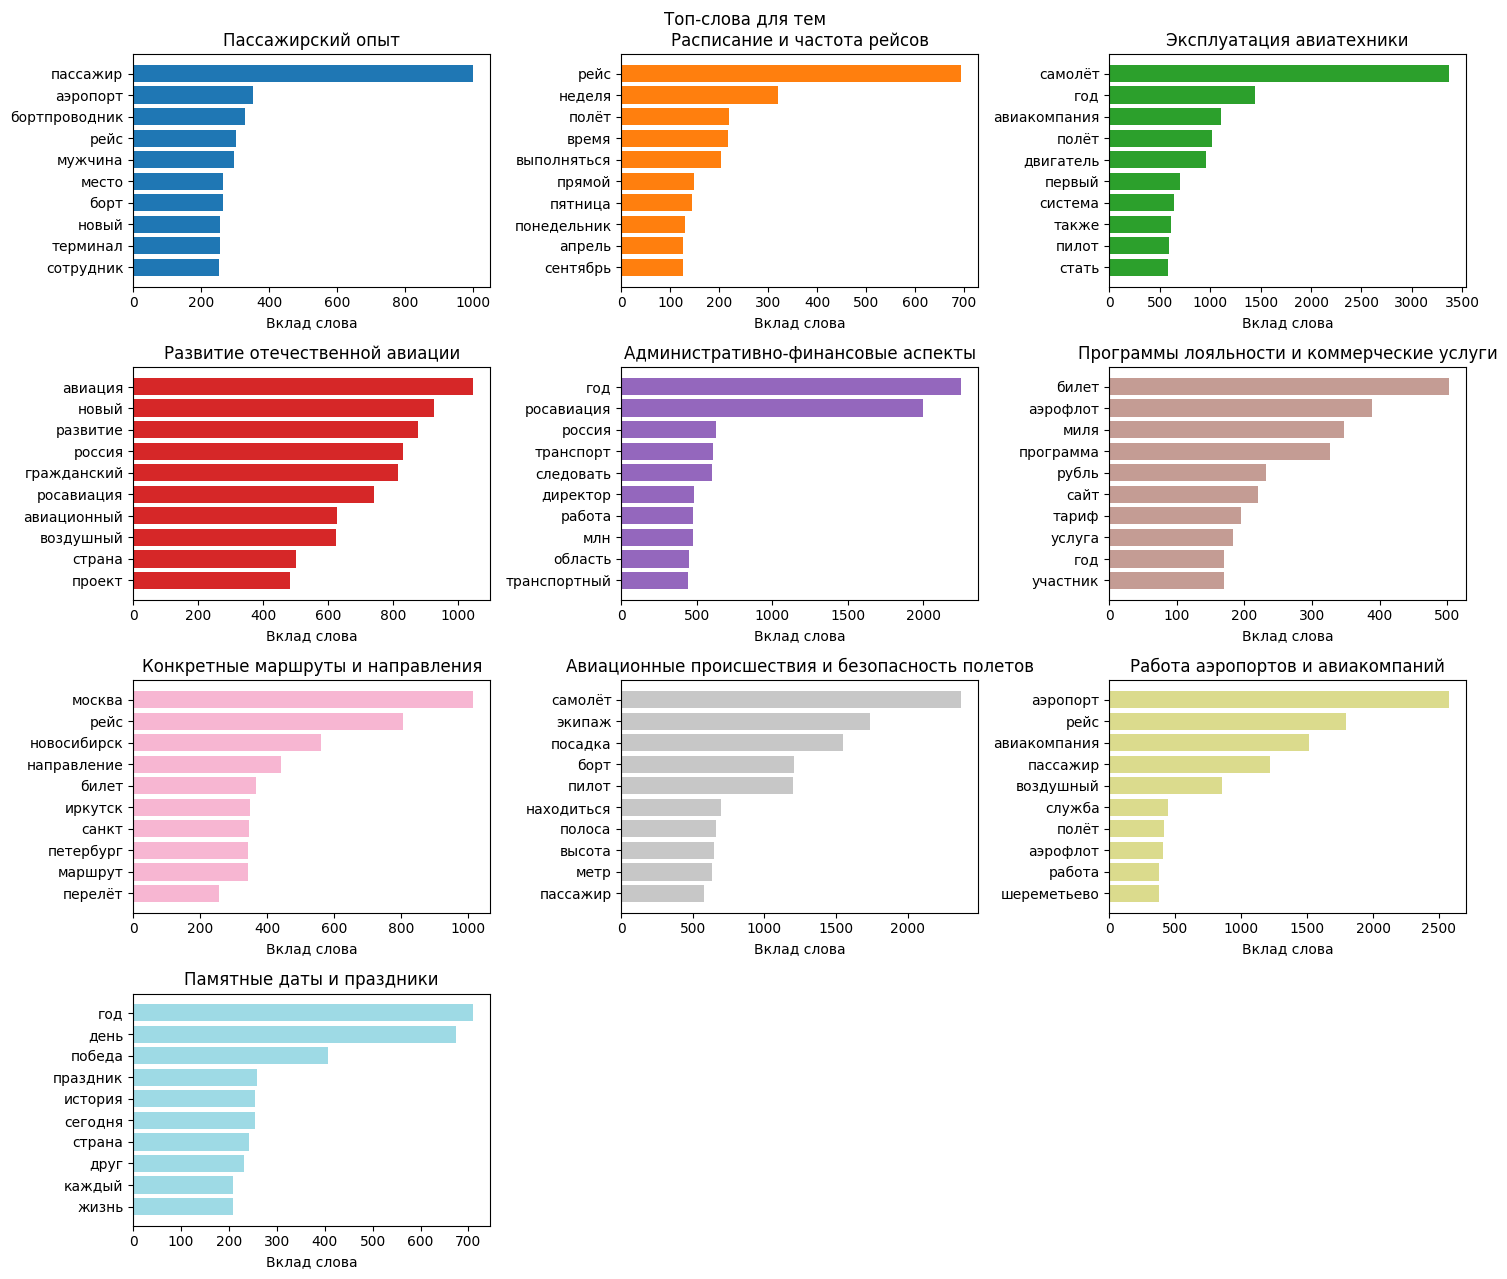

In [169]:
fig1, fig2, fig3, fig4 = visualize_lda_nmf_model(lda_best_model[0], lda_best_model[1], lda_topics, 'LDA')

### NMF

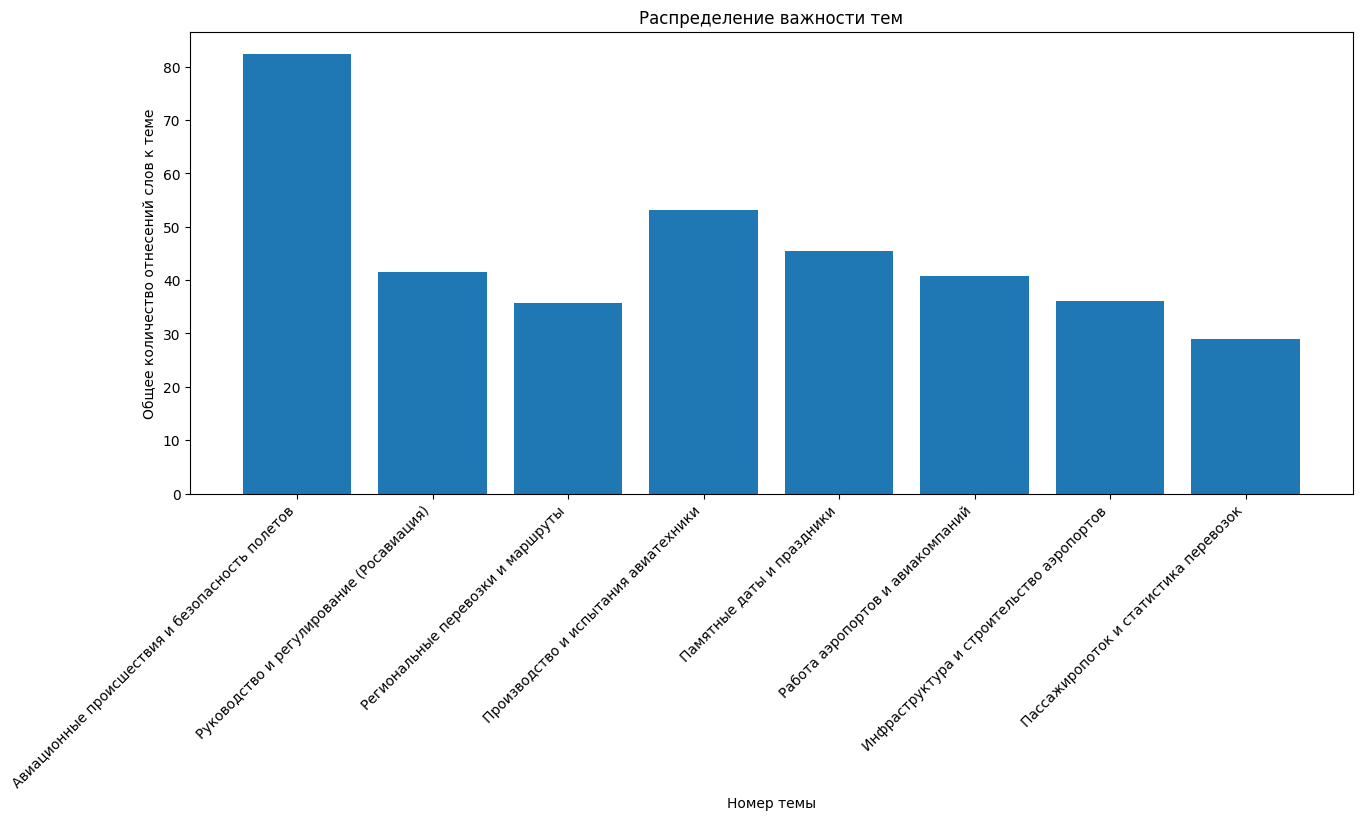

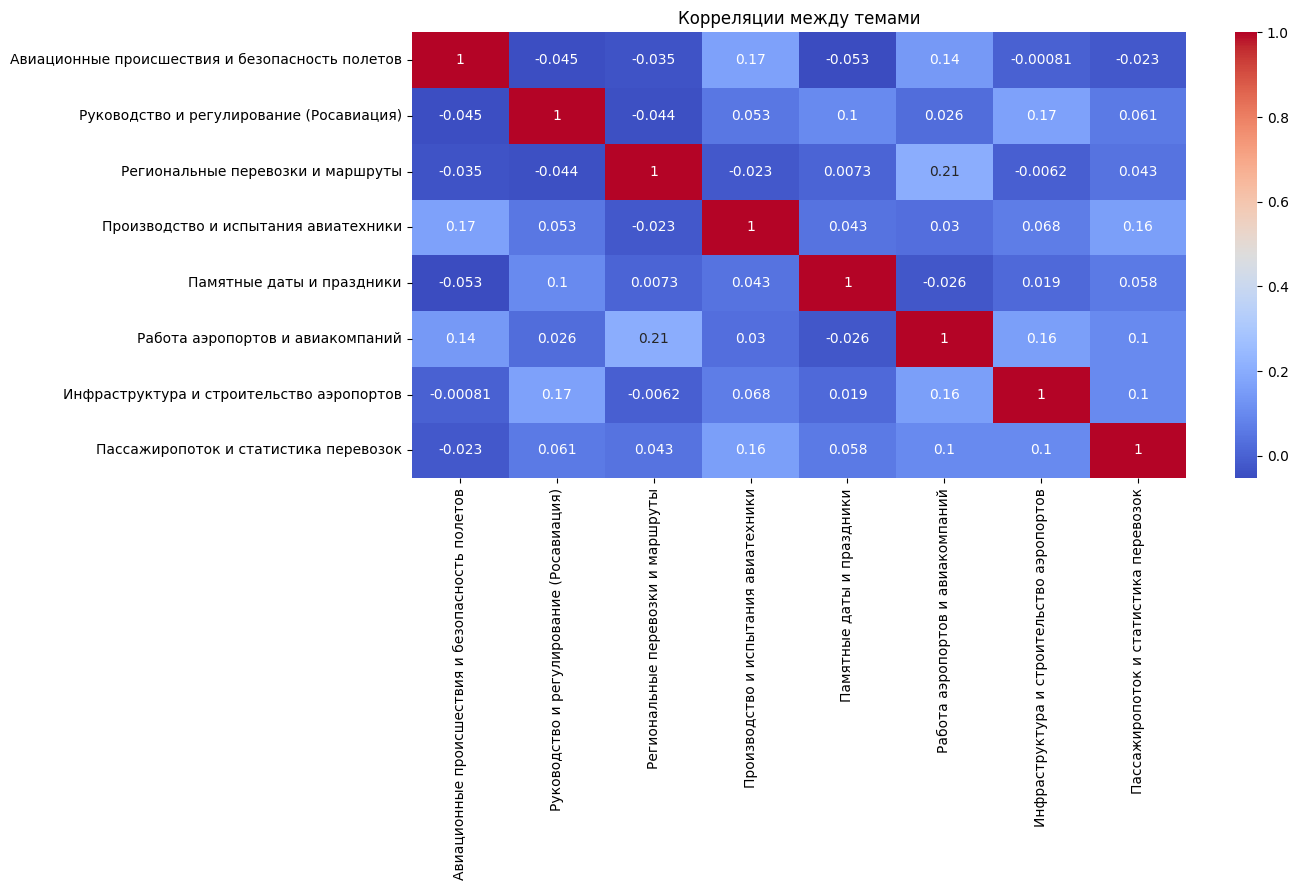

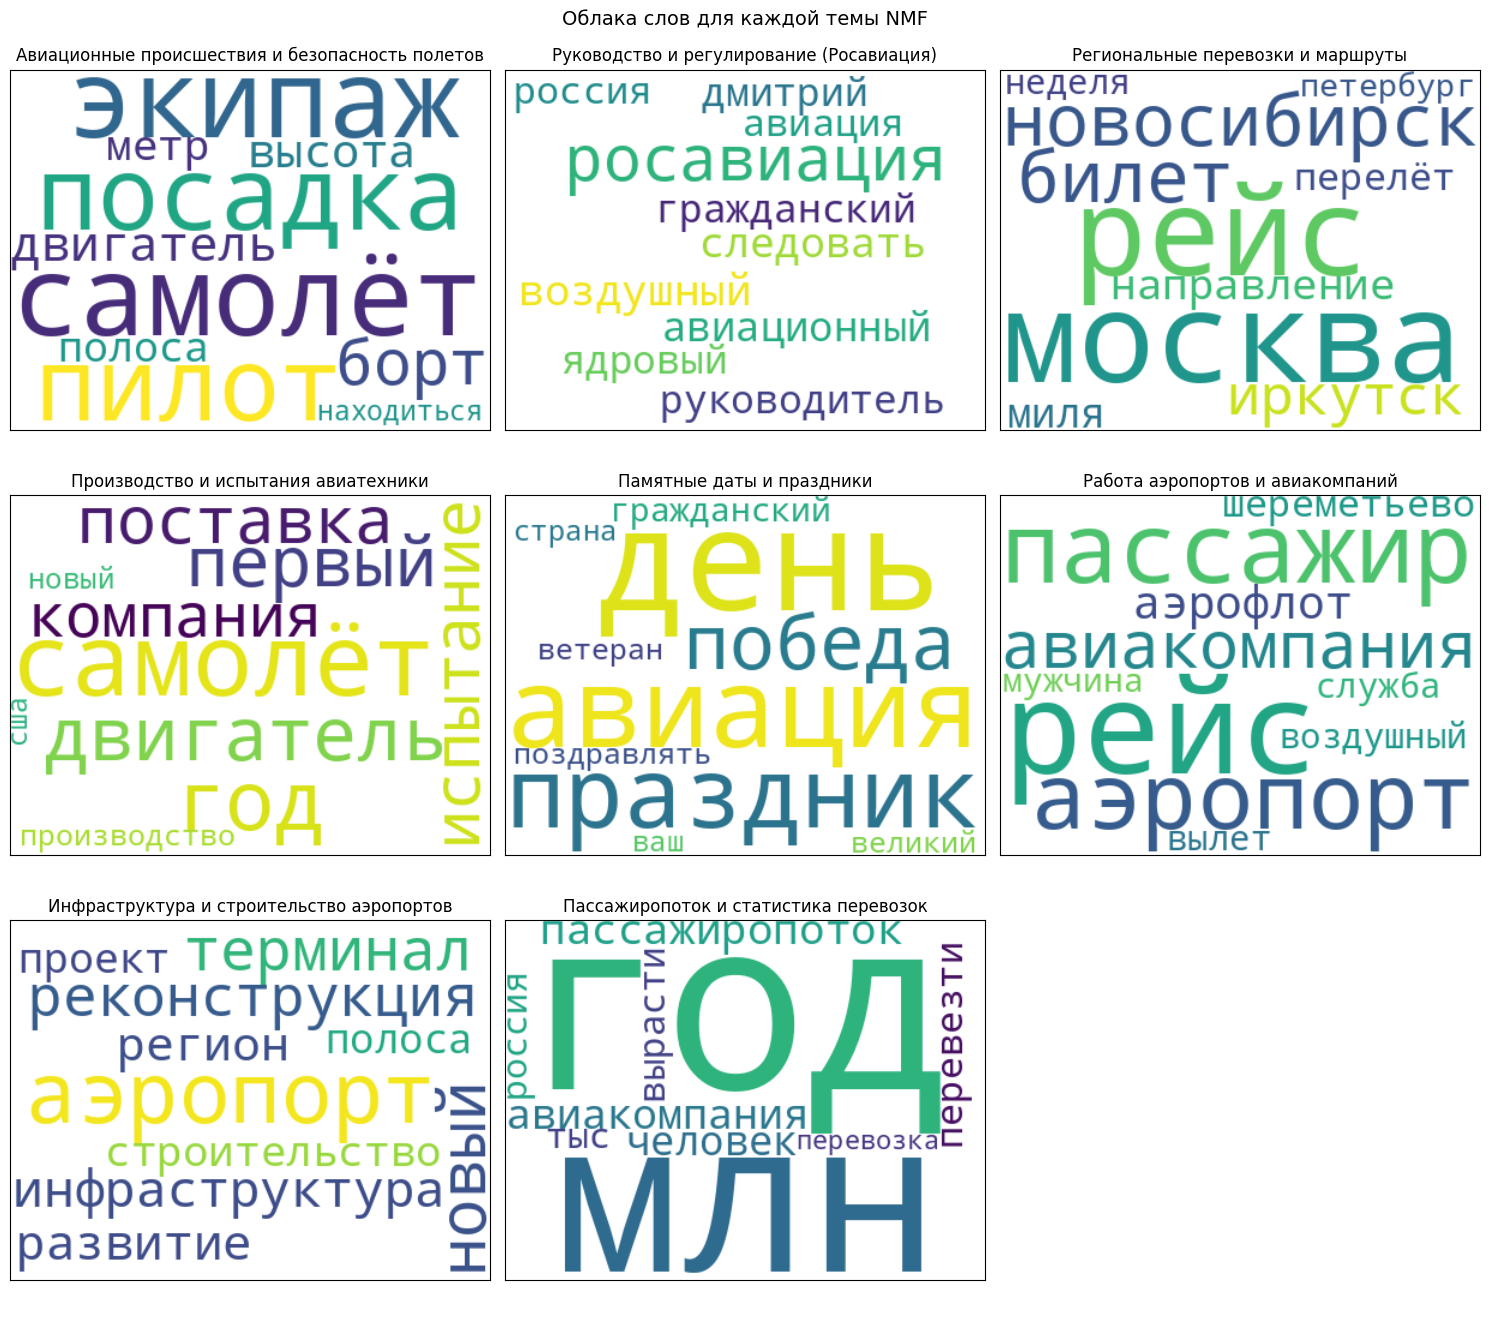

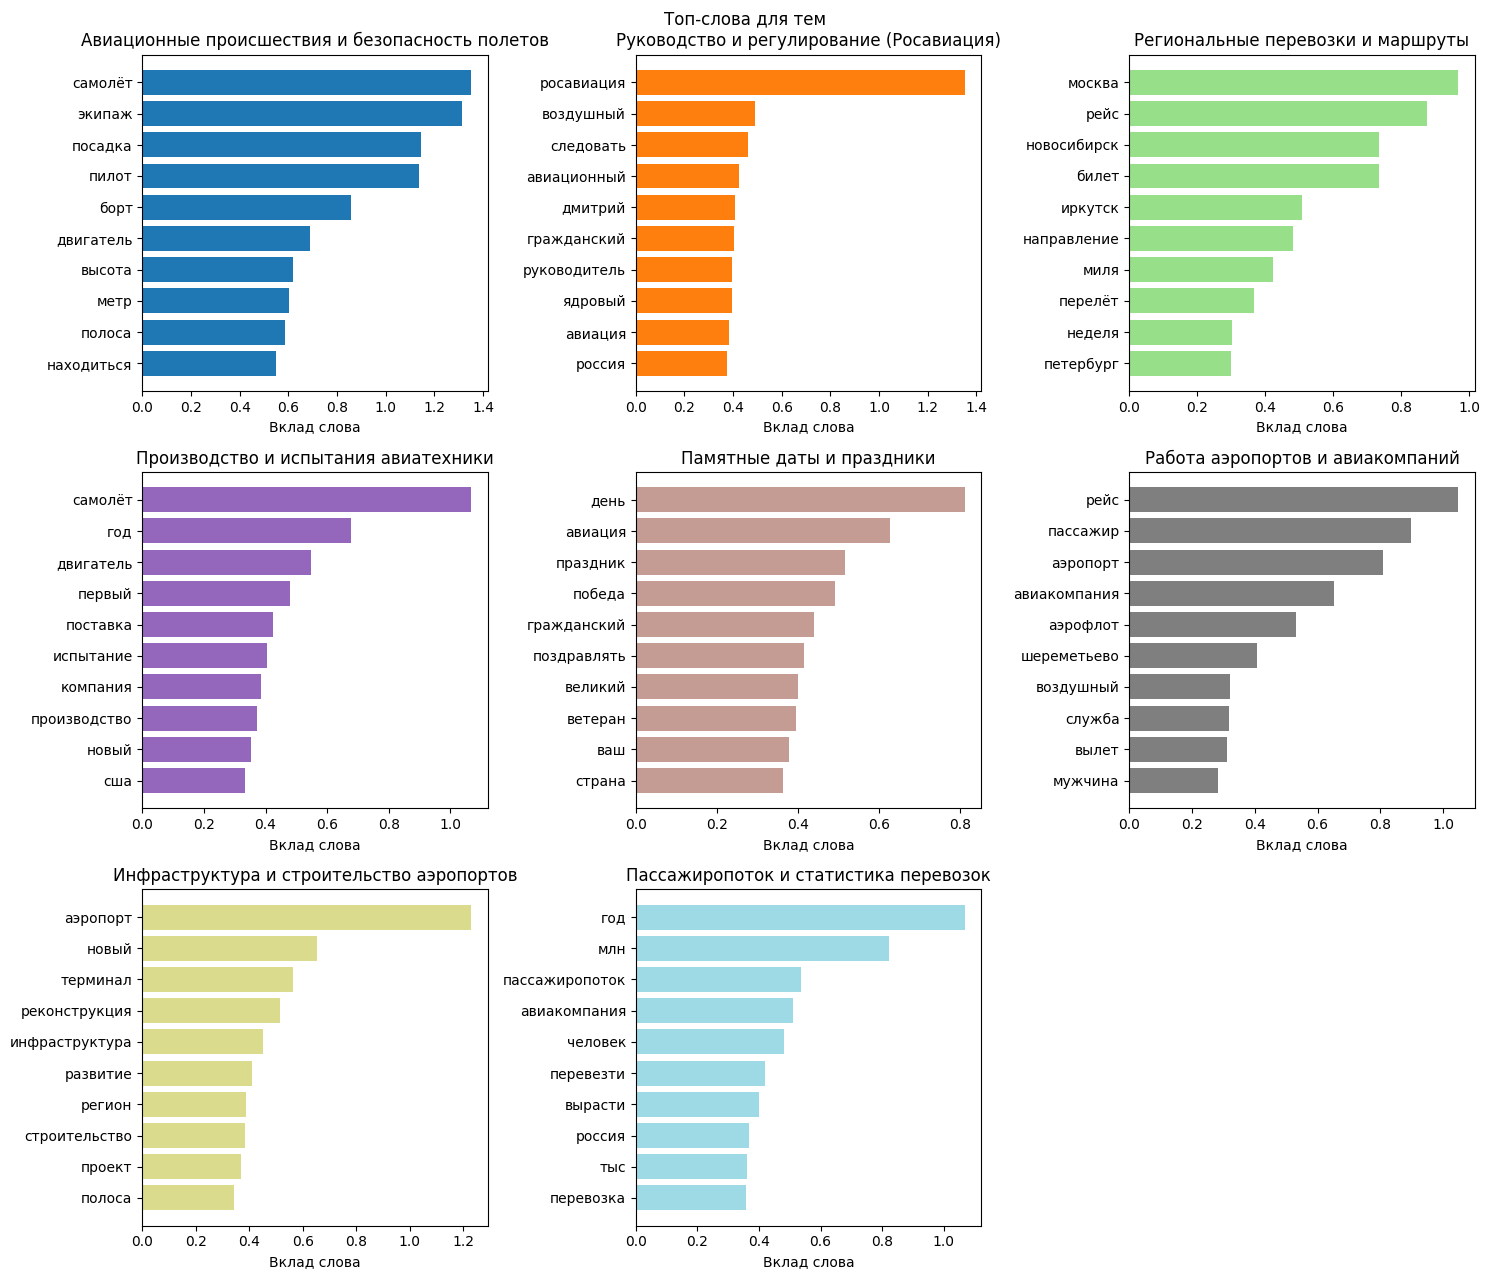

In [170]:
fig1, fig2, fig3, fig4 = visualize_lda_nmf_model(nmf_best_model[0], nmf_best_model[1], nmf_topics, 'NMF')

### BERTopic

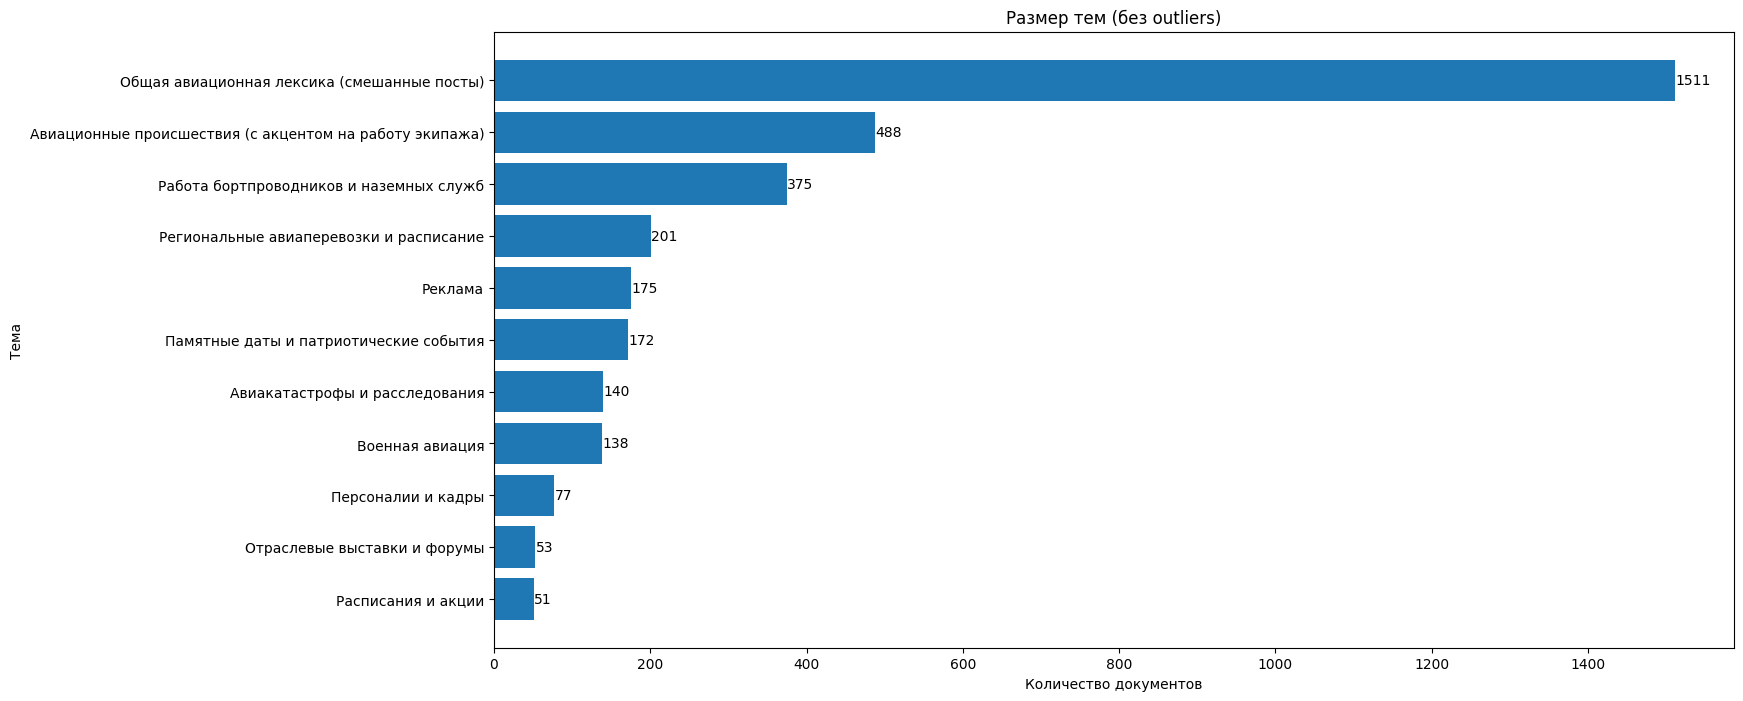

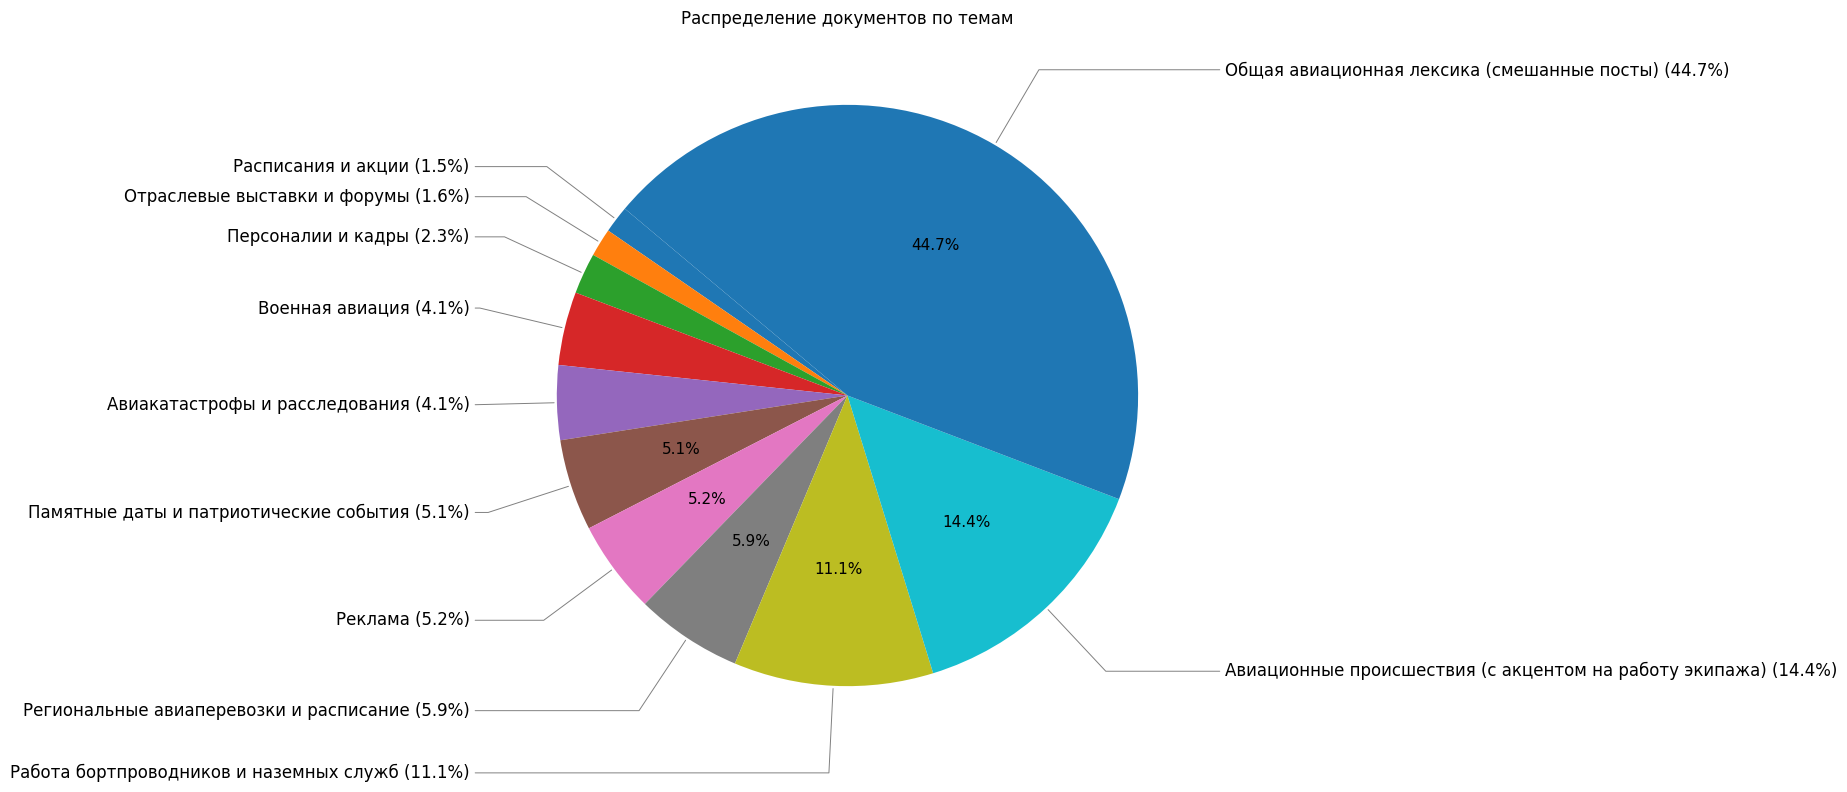

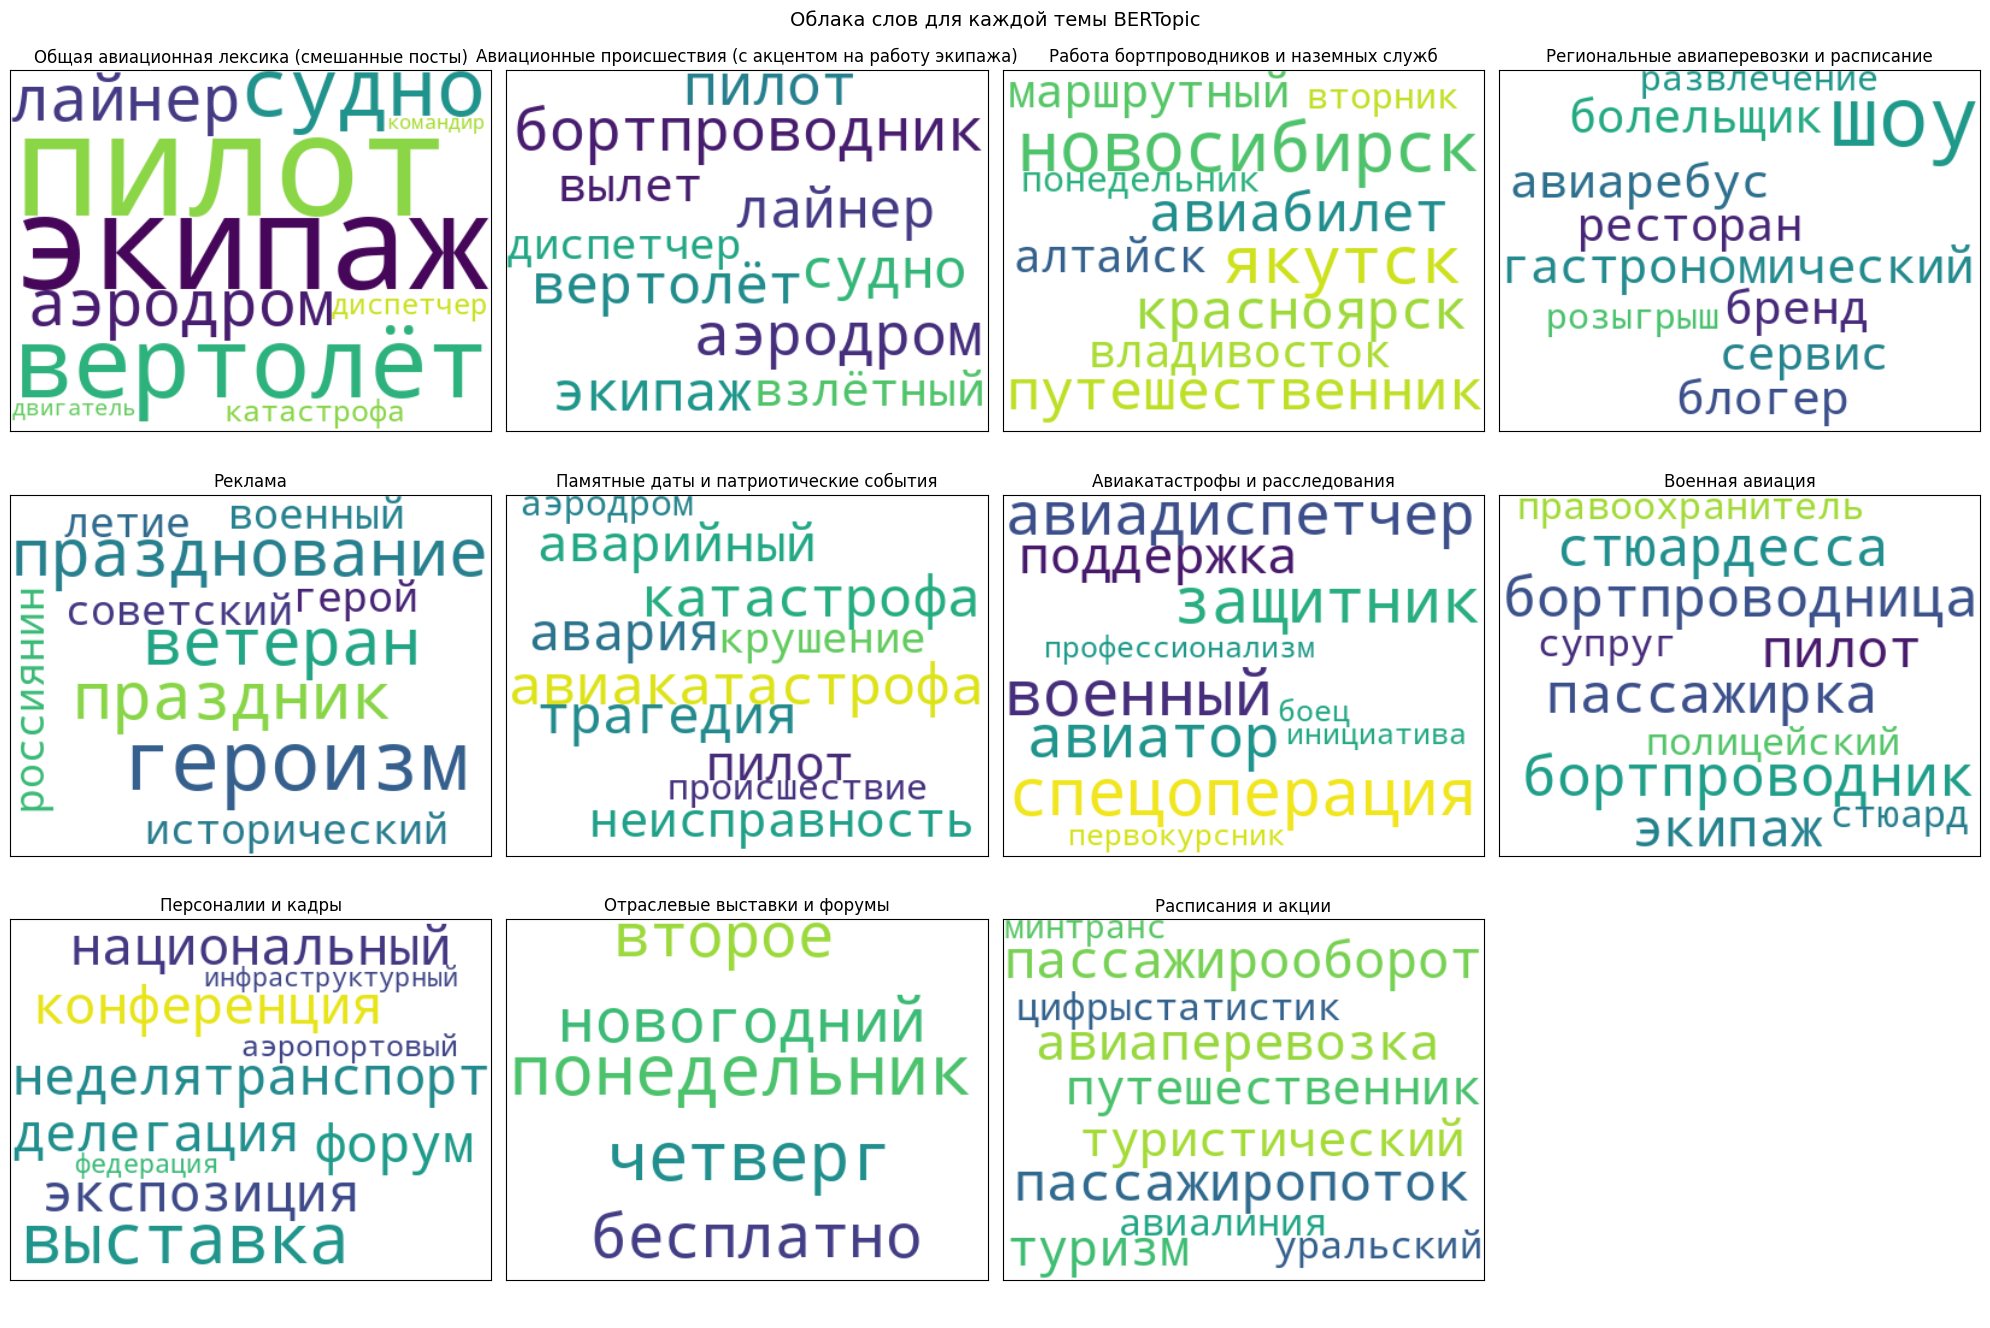

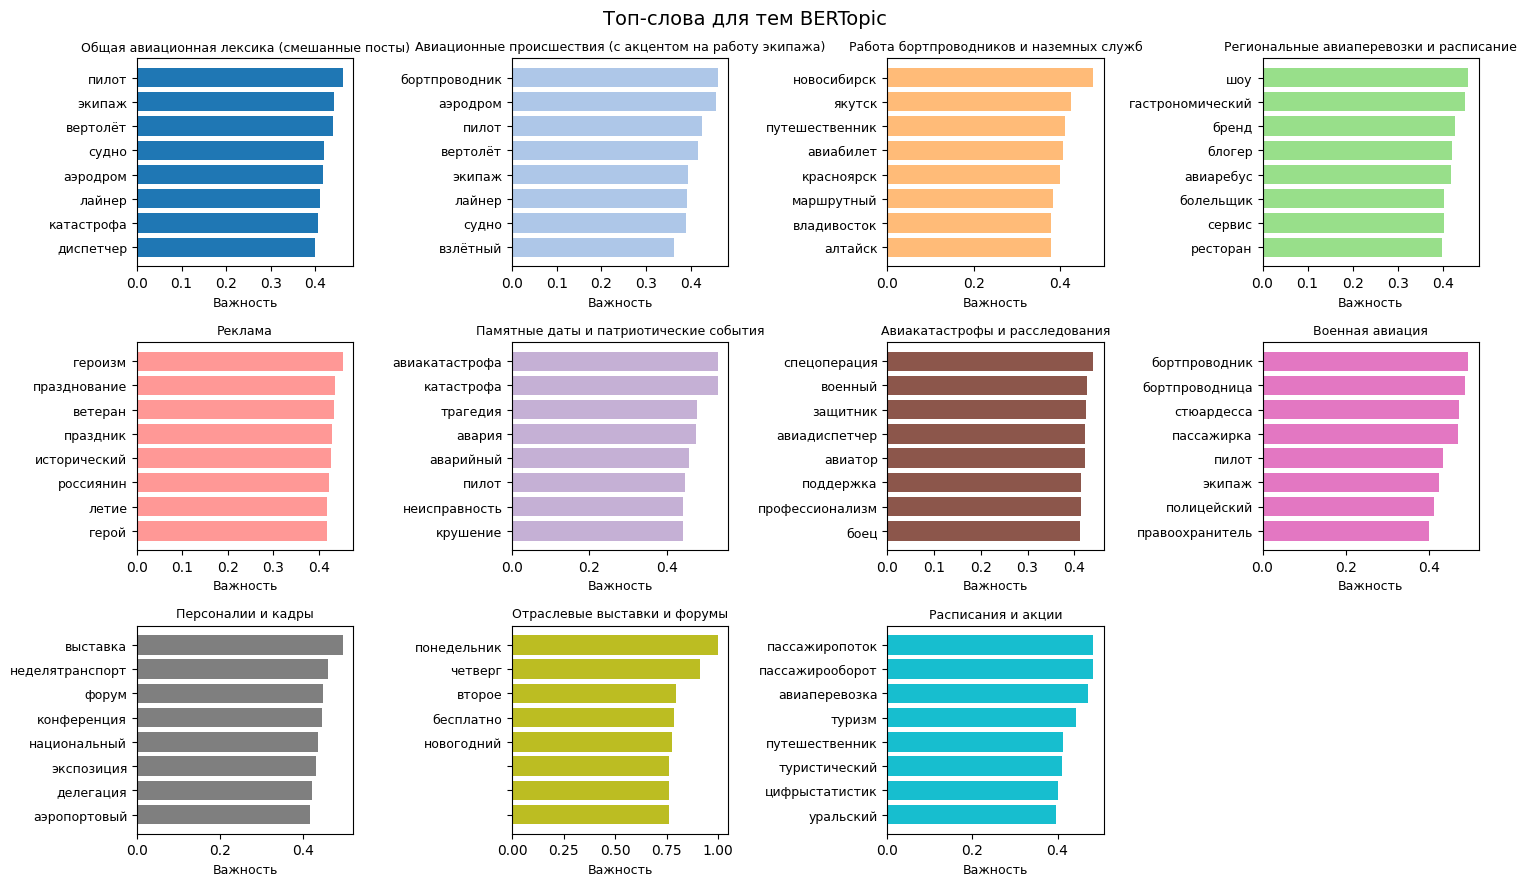

In [ ]:
def visualize_bertopic_model(topic_model, topics=None):
    
    topic_info = topic_model.get_topic_info()
    
    topics_filtered = topic_info[topic_info['Topic'] != -1]
    
    topics_filtered_sorted = topics_filtered.sort_values('Count', ascending=True)
    topics_sorted = []
    for topic_id in topics_filtered_sorted['Topic']:
        idx = list(topics_filtered['Topic']).index(topic_id)
        topics_sorted.append(topics[idx])
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
    
    # Гистограмма
    bars1 = ax1.barh(topics_sorted, topics_filtered_sorted['Count'])
    ax1.set_xlabel('Количество документов')
    ax1.set_ylabel('Тема')
    ax1.set_title('Размер тем (без outliers)')
    
    for bar, count in zip(bars1, topics_filtered_sorted['Count']):
        ax1.text(count + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{count}', va='center')
    
    fig1, ax2 = plt.subplots(1, 1, figsize=(16, 8))
    # Круговая диаграмма - убираем проценты для маленьких категорий
    percentages = (topics_filtered_sorted['Count'] / topics_filtered_sorted['Count'].sum() * 100)
    
    # Определяем порог для отображения процентов (например, меньше 5%)
    threshold = 5
    
    def custom_autopct(pct):
        return f'{pct:.1f}%' if pct >= threshold else ''
    
    wedges, texts, autotexts = ax2.pie(
        percentages, 
        labels=None,
        autopct=custom_autopct, 
        startangle=140,
        textprops={'fontsize': 11}
    )
    ax2.set_title('Распределение документов по темам')

    kw = dict(arrowprops=dict(arrowstyle="-", color="gray", lw=0.7),
            zorder=0, va="center")
    
    for i, (p, label) in enumerate(zip(wedges, topics_sorted)):
        if percentages.iloc[i] < 1:  # Для очень маленьких секций пропускаем подписи
            continue
            
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        
        # Определяем позицию текста
        xytext_x = 1.3 * np.sign(x)
        xytext_y = 1.3 * y
        
        ax2.annotate(
            f"{label} ({percentages.iloc[i]:.1f}%)",
            xy=(x, y),
            xytext=(xytext_x, xytext_y),
            horizontalalignment=horizontalalignment,
            fontsize=12,
            **kw
        )
    
    plt.tight_layout()
    plt.show()
    
    # Облака слов
    
    n_topics = len(topics_filtered)
    
    if n_topics <= 4:
        n_cols = 2
        n_rows = 2
    elif n_topics <= 9:
        n_cols = 3
        n_rows = 3
    else:
        n_cols = 4
        n_rows = 3
    
    fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4.5))
    axes2 = axes2.flatten()
    
    # Сортируем темы по ID для соответствия названиям
    topics_filtered = topics_filtered.sort_values('Topic')
    
    for idx, (_, row) in enumerate(topics_filtered.iterrows()):
        ax = axes2[idx]
        topic_id = row['Topic']
        
        # Получаем топ-слова
        topic_words = topic_model.get_topic(topic_id)
        word_dict = {w[0]: w[1] for w in topic_words[:10]}
        
        wordcloud = WordCloud(
            width=400, 
            height=300, 
            background_color='white',
            colormap='viridis',
            max_words=10
        ).generate_from_frequencies(word_dict)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(topics[idx])
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(len(topics_filtered), len(axes2)):
        axes2[idx].axis('off')
    
    plt.suptitle('Облака слов для каждой темы BERTopic', fontsize=14)
    plt.tight_layout()
    plt.show()

    fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))
    
    axes3 = axes3.flatten()
    fig3.suptitle('Топ-слова для тем BERTopic', fontsize=14)
    
    for idx, (_, row) in enumerate(topics_filtered.iterrows()):
        ax = axes3[idx]
        topic_id = row['Topic']
        
        # Получаем топ-слова
        topic_words = topic_model.get_topic(topic_id)
        words = [w[0] for w in topic_words[:8]]
        scores = [w[1] for w in topic_words[:8]]
        
        bars = ax.barh(range(len(words)), scores, color=plt.cm.tab20(idx/n_topics))
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_title(topics[idx], fontsize=9)
        ax.set_xlabel('Важность', fontsize=9)
        ax.invert_yaxis()
    
    # Скрываем пустые subplots
    for idx in range(len(topics_filtered), len(axes3)):
        axes3[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 80)
    
    return {
        'topic_info': topic_info,
        'topics_filtered': topics_filtered,
        'topics': topics,
        'figures': [fig1, fig2, fig3]
    }

bertopic_results = visualize_bertopic_model(bertopic_best_model["model"], bertopic_topics)